In [1]:
### USING ALL DIFF EXP (1335)-(Lasso and RFE 100 overlap feature elimination)+No PCA+SMOTE+50 REPEATS = 12 FEATURES

'''
Find the best n transcripts by April 29th
    - do feature selection with: 1) Lasso 2) RFE 3) Boruta 4) RF 5) Any Combo - done
    - run LassoLR, RF, Pamr, XgBoost, Boruta over all diff expressed genes - done
    - store running array of sorted descending RF variable importance if AUC > 0.7 - done!
    - store running array of sorted descending LassoLR coefficient size if AUC > 0.7 - done!
    - store running array of sorted descending XgBoost coefficient size if AUC > 0.7 - done!
    - store running array of sorted descending Boruta coefficient size if AUC > 0.7 - done!
    - find the intersection of the top n genes that gives x important genes  - done!
    - rerun the best model on ALL the data with only the top x important genes - done!

TODO Figures:

Subanalysis: use PHATE to visualize features

1) Top 12 best overlapping forward pass -> add PFS and OS of class I vs class II in the test set
2) Top 12 best overlapping -> retrain on the full dataset with the best params and SAVE - done!
3) SAVED Top 12 overlapping -> test on the new test dataset with survival 
    (unfortunately first validation set only had one Grade I tumor)
    (try with validation set #2 as well!)
4) External validation bootstrapped F1 scores bar plot
5) Summary slides of methods for audience
6) Optional: Kaplan-Meier Curves on train/test labels - done!

'''

'\nFind the best n transcripts by April 29th\n    - do feature selection with: 1) Lasso 2) RFE 3) Boruta 4) RF 5) Any Combo - done\n    - run LassoLR, RF, Pamr, XgBoost, Boruta over all diff expressed genes - done\n    - store running array of sorted descending RF variable importance if AUC > 0.7 - done!\n    - store running array of sorted descending LassoLR coefficient size if AUC > 0.7 - done!\n    - store running array of sorted descending XgBoost coefficient size if AUC > 0.7 - done!\n    - store running array of sorted descending Boruta coefficient size if AUC > 0.7 - done!\n    - find the intersection of the top n genes that gives x important genes  - done!\n    - rerun the best model on ALL the data with only the top x important genes - done!\n\nTODO Figures:\n\nSubanalysis: use PHATE to visualize features\n\n1) Top 12 best overlapping forward pass -> add PFS and OS of class I vs class II in the test set\n2) Top 12 best overlapping -> retrain on the full dataset with the best p

In [2]:
# TODO: Revisit normalizing transcripts based on tissue type

# Toggle to use two-class labels or three class labels
two_class = True; three_class = False #(Grade I/II, Grade III/IV)
# three_class = True; two_class = False # (Grade I, Grade II, Grade III/IV)

# Toggle to use_differentially_expressed_genes
use_differentially_expressed_genes=True; first_n_diff_exp_genes = None # Use all differentially expressed genes
# use_differentially_expressed_genes=True; first_n_diff_exp_genes = 500 # Use top 500 differentially expressed genes
# use_differentially_expressed_genes=False # use all 19904 genes

# Toggle to discretize z-scores into 3 or 5 groups (or don't discretize at all)
# discretize_z_three = True; discretize_z_five = False
# discretize_z_five = True; discretize_z_three = False
discretize_z_five = False; discretize_z_three = False

# Toggle to use various feature reduction methods (comment out/in as many as needed)
use_lasso=True
# use_lasso=False
use_rfe=True; number_of_rfe_genes_to_keep = 100
# use_rfe=False
use_rf=True
# use_rf=False
use_boruta=True
# use_boruta=False

# Toggle to use PCA to reduce dimensionality of data before passing into the algorithm
# use_PCA=True; number_of_PCA_components = 10 # number_of_PCA_components must be less than first_n_diff_exp_genes
use_PCA=False

# We are using a bootstrap nested repeated k-fold cross validation procedure for training and testing
# Decide the number of bootstraps to bootstrap the CV
num_bootstrap_iterations = 100

# Decide the number of repeats to run the repeated CV
# num_repeats = 50
num_repeats = 1

# Decide the number of k-splits to run the k-fold CV
num_splits = 5


In [3]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import json
import pandas as pd
import mygene
from tqdm import tqdm
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.datasets import load_iris, make_classification
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, ParameterGrid, train_test_split
from torch.utils.data import DataLoader, TensorDataset
from sklearn.decomposition import PCA
from sklearn.preprocessing import label_binarize
from itertools import cycle
from functools import reduce
from imblearn.over_sampling import SMOTE
import torch.backends.cudnn as cudnn
from sklearn.metrics import f1_score, confusion_matrix, accuracy_score, roc_auc_score, roc_curve, auc
from sklearn.model_selection import KFold, train_test_split
from sklearn.linear_model import LassoCV
from sklearn.feature_selection import RFE
from boruta import BorutaPy
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn import svm
from sklearn.utils import resample
from collections import defaultdict
from lifelines import KaplanMeierFitter
from lifelines.statistics import logrank_test
from scipy import stats

# Set the random seed
torch.manual_seed(42)
cudnn.deterministic = True

In [4]:
'''
Define models
'''

class LogisticRegression(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LogisticRegression, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        if three_class:
            return nn.functional.softmax(self.linear(x), dim=1)
        elif two_class:
            return self.linear(x)
        else:
            pass

def glorot_normal_initialization(layer):
    if type(layer) == nn.Linear:
        nn.init.xavier_normal_(layer.weight)

def train(model, loader, optimizer, criterion):
    model.train()
    for batch_x, batch_y in loader:
        optimizer.zero_grad()
        if three_class:
            outputs = model(batch_x)
        elif two_class:
            outputs = model(batch_x).flatten()
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()

def evaluate(model, loader):
    model.eval()
    total = 0
    correct = 0
    with torch.no_grad():
        for batch_x, batch_y in loader:
            if three_class:
                outputs = model(batch_x)
            elif two_class:
                outputs = model(batch_x).flatten()
            if three_class:
                _, predicted = torch.max(outputs, 1)
            elif two_class:
                predicted = (outputs > 0.5).long()
            total += batch_y.size(0)
            correct += (predicted == batch_y).sum().item()
    return correct / total

def generate_ternary_class_label(grade):
    """
    To get three classes from the provided data
    'G1' will be kept as 'G1'
    'G2' will be kept as 'G2'
    'G3' will be kept as 'G3'
    'G4' and 'GX' will be excluded
    """
    if grade in ['G1', '1 - Well differentiated', 'Well differentiated']:
        return 0 # 'G1'
    elif grade in ['G2', '2 - Moderately differentiated', 'Moderately differentiated ']:
        return 1 # 'G2'
    elif grade in ['G3','3 - Poorly differentiated', 'Poorly differentiated', 'Moderate to Poor']:
        return 2 # 'G3'
    elif grade in ['G4', '4 - Undifferentiated', 'Undifferentiated', 'Poorly differentiated to Undifferentiated', 'GX', 'X - Cannot be assessed', 'Not specified/Unknown']:
        return np.nan
    else:
        return np.nan

def generate_binary_class_label(grade):
    """
    To get two classes from the provided data
    'G1' will be kept as 'G1'
    'G2' will be changed to 'G2/3'
    'G3' will be changed to 'G2/3'
    'G4' and 'GX' will be excluded
    """
    if grade in ['G1', '1 - Well differentiated', 'Well differentiated']:
        return 0 # 'G1'
    elif grade in ['G2', '2 - Moderately differentiated', 'Moderately differentiated ']:
        return 1 # 'G2/3'
    elif grade in ['G3','3 - Poorly differentiated', 'Poorly differentiated', 'Moderate to Poor']:
        return 1 # 'G2/3'
    elif grade in ['G4', '4 - Undifferentiated', 'Undifferentiated', 'Poorly differentiated to Undifferentiated', 'GX', 'X - Cannot be assessed', 'Not specified/Unknown']:
        return np.nan
    else:
        return np.nan
    
def convert_ensembl_gene_ids_to_symbol_entrez(gene_ids, batch_size=1000):
    # Convert ensembl gene ids to symbol and entrezgene in batches
    gene_id_to_symbol_entrez = {}
    for i in range(0, len(gene_ids), batch_size):
        batch = gene_ids[i:i+batch_size]
        result = mg.querymany(batch, scopes='ensembl.gene', fields='symbol,entrezgene')
        for gene in result:
            if 'notfound' not in gene:
                gene_id_to_symbol_entrez[gene['query']] = (gene.get('symbol'), gene.get('entrezgene'))
    return gene_id_to_symbol_entrez


In [5]:
# '''
# Load in the data
# '''

# # Dataset 1a (Train Dataset): RNA transcripts centered and converted to Z-scores relative to all samples
# df_X = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep='\t', index_col=[0, 1])

# # Dataset 1b: RNA transcripts centered and converted to Z-scores relative to diploid samples
# # df_X = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_diploid_samples.txt", sep='\t', index_col=[0, 1])

# # Dataset 1c: Protein expression levels centered and converted to Z-scores relative to all samples
# # df_X = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_rppa_zscores.txt", sep='\t', index_col=[0, 1])

# # Differentially Expressed Genes Dataset:
# df_X_diff_G1    = pd.read_csv('RE_ Molecular profiling Project/TCGA 2018 PDAC N_171 - DE genes enriched in G1 (vs G2-3).tsv', sep='\t')
# df_X_diff_G2_G3 = pd.read_csv('RE_ Molecular profiling Project/TCGA 2018 PDAC N_171 - DE genes enriched in G2-3 (vs G1).tsv', sep='\t')

# if first_n_diff_exp_genes:
#     df_X_diff_G1 = df_X_diff_G1.head(round(first_n_diff_exp_genes/2)).copy()
#     df_X_diff_G2_G3 = df_X_diff_G2_G3.head(round(first_n_diff_exp_genes/2)).copy()

# differentially_expressed_gene_set = set(df_X_diff_G1['Gene']).union(set(df_X_diff_G2_G3['Gene'])) # Using genes differentally expressed in G1 OR G2/3
# # differentially_expressed_gene_set = set(df_X_diff_G1['Gene']).union(set(df_X_diff_G1['Gene'])) # Only using genes differentally expressed in G1 vs G2/3
# # differentially_expressed_gene_set = set(df_X_diff_G2_G3['Gene']).union(set(df_X_diff_G2_G3['Gene'])) # Only using genes differentally expressed in G2/3 vs G1

# # Dataset 1 Labels A: Patients labeled by tumor GRADE
# df_y = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_sample.txt", sep='\t', index_col=[0, 1])

# # Dataset 1 Labels B: Patients labeled by tumor STAGE # Deprecated
# # df_y = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_patient.txt", sep='\t', index_col=[0, 1])
# # df_y['Neoplasm Disease Stage American Joint Committee on Cancer Code'].unique()
# # Unique values include 'STAGE I','STAGE IA', 'STAGE IB', 'STAGE IIA', 'STAGE IIB', 'STAGE III','STAGE IV'

# if three_class:
#     # Update the class labels according to the generate_trinary_class_label function
#     df_y['Neoplasm Histologic Grade'] = df_y['Neoplasm Histologic Grade'].apply(generate_ternary_class_label)
#     # OR
# if two_class:
#     # Update the class labels according to the generate_binary_class_label function
#     df_y['Neoplasm Histologic Grade'] = df_y['Neoplasm Histologic Grade'].apply(generate_binary_class_label)

# # Remove patients that do not have a tumor grade assigned or are grade 4
# df_y.dropna(subset=['Neoplasm Histologic Grade'], inplace=True)

# # Next, transpose the MRNA seq scores so that each row corresponds to a patient and each column corresponds to a feature or mRNA expression level
# df_X = df_X.transpose()

# # Remove all columns (features) with any NaN values
# df_X = df_X.dropna(axis=1)

# # Print the size of the gene set
# print(f'Number of differentially expressed genes: {len(differentially_expressed_gene_set)}')
# # Print the size of the filtered dataframe
# print(f'Total number of genes in transcript dataset: {df_X.shape[1]}')
# if use_differentially_expressed_genes:
#     # Drop columns in df_X that are not in the differentially expressed gene set
#     df_X = df_X.drop(columns=[col for col in df_X.columns if col[0] not in differentially_expressed_gene_set])
# print(f'Total number of differentially expressed genes in transcript dataset: {df_X.shape[1]}')

# # Keep only patient IDs with both mRNA sequence data AND tumor grade values
# X = df_X
# y = df_y['Neoplasm Histologic Grade']

# # Find common patient IDs
# X.index = X.index.str.replace('-01', '')
# common_ids = list(set(X.index) & set(y.index.get_level_values('#Patient Identifier')))

# # Filter X and y to contain only common patient IDs
# X_common = X.loc[common_ids]
# y_common = y.loc[y.index.get_level_values('#Patient Identifier').isin(common_ids)]

# # Sort X and y by patient ID
# X_common.sort_index(inplace=True)
# y_common.sort_index(inplace=True)

# # print(X_common.head())
# # print(y_common.head())

# # Convert X and y to arrays
# X = X_common.values
# y = y_common.values

# # Discretize z scores (optional - we won't do this for now because it doesn't improve results)
# if discretize_z_three:
#     # Ternarize X (ternarized normalization discretized the Z-scores into down-regulated (Z<−2), normal (−2<Z<2), or up-regulated (Z>2) categories)
#     X = np.where(X < -2, -1, np.where(X > 2, 1, 0))

# if discretize_z_five:
#     # Discretize the Z-scores into 
#     # Very downregulated: Z <= -2 (assigned as -2)
#     # Downregulated: -2 < Z <= -1 (assigned as -1)
#     # Normal: -1 < Z <= 1 (assigned as 0)
#     # Upregulated: 1 < Z <= 2 (assigned as 1)
#     # Very upregulated: Z > 2 (assigned as 2)
#     X = np.where(X <= -2, -2, np.where(X <= -1, -1, np.where(X <= 1, 0, np.where(X <= 2, 1, 2))))


In [6]:
# TODO: Add in the GAF conversion to the code. Add in the TPM, log transform and z-score conversion into the code as well. Redo the train preprocessing code to get the mean and std_dev and plot the before and after

# def get_data(filename):
#     """
#     Load the data from a CSV file.
    
#     Args:
#         filename (str): Name of the file to load.
        
#     Returns:
#         DataFrame: Pandas dataframe with the data.
#     """
    
#     return pd.read_csv(filename, sep='\t', index_col=[0, 1])

# def convert_to_log_transform(df, column_name='TPM'):
#     """
#     Apply a log transform to the data. Replace negative values with 0 and add a pseudo-count (+1) before transforming.
    
#     Args:
#         df (DataFrame): Dataframe with the values to transform.
#         column_name (str): Name of the column to apply the transformation.
        
#     Returns:
#         DataFrame: Transformed dataframe.
#     """
#     df['log_' + column_name] = df[column_name].apply(lambda x: np.log2(max(x, 0) + 1))
#     return df

# def convert_to_z_score(df, column_name='log_TPM', mean=None, std_dev=None):
#     """
#     Convert the data to Z-scores using provided mean and standard deviation. If none are provided, compute from the data.
    
#     Args:
#         df (DataFrame): Dataframe with the values to convert.
#         column_name (str): Name of the column to apply the conversion.
#         mean (float, optional): Mean to use for Z-score normalization.
#         std_dev (float, optional): Standard deviation to use for Z-score normalization.
        
#     Returns:
#         DataFrame: Transformed dataframe.
#         float: Mean of the data.
#         float: Standard deviation of the data.
#     """
#     if mean is None or std_dev is None:
#         mean = df[column_name].mean()
#         std_dev = df[column_name].std()
        
#     df['z_score_' + column_name] = (df[column_name] - mean) / std_dev
#     return df, mean, std_dev

# def convert_FPKM_to_TPM(df, column_name='FPKM'):
#     """
#     Convert FPKM values to TPM.
    
#     Args:
#         df (DataFrame): Dataframe with FPKM values.
#         column_name (str): Name of the column containing FPKM values.
        
#     Returns:
#         DataFrame: Transformed dataframe with TPM values.
#     """
#     total_FPKM = df[column_name].sum()
#     df['TPM'] = df[column_name] / total_FPKM * 1e6
#     return df

# def preprocess_data(raw_df_X, mean=None, std_dev=None, X_col_name = None, convert_fpkm_to_tpm = False):
#     """
#     Preprocess the data by converting to TPM, log transforming, and z-scoring
#     X_col_name is the column name which we get the TPM from (or convert FPKM to TPM from)
#     """
#     if convert_fpkm_to_tpm:
#         raw_df_X = convert_FPKM_to_TPM(raw_df_X,column_name=X_col_name)
#     else:
#         raw_df_X['TPM'] = ... # It should equal the tpm gene expression value
#     log_df_X = convert_to_log_transform(raw_df_X)
#     df_X, mean, std_dev = convert_to_z_score(log_df_X, mean=mean, std_dev=std_dev)
#     return df_X, mean, std_dev

# raw_TPM_train_df_X = get_data("paad_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt.txt")
# train_df_X, train_mean, train_std_dev = preprocess_data(raw_TPM_train_df_X)

# # log_TPM_train_df_X = convert_to_log_transform(raw_TPM_train_df_X)
# # train_df_X, train_mean, train_std_dev = convert_to_z_score(log_TPM_train_df_X)

# raw_FPKM_test_df_X = get_data("icgc-dataset-1695156575358/exp_seq.tsv")
# test_df_X,_,_ = preprocess_data(raw_FPKM_test_df_X, mean=train_mean, std_dev=train_std_dev,X_col_name='normalized_read_count')

# # raw_TPM_test_df_X = convert_FPKM_to_TPM(raw_FPKM_test_df_X)
# # log_TPM_test_df_X = convert_to_log_transform(raw_TPM_test_df_X)
# # test_df_X,_,_ = convert_to_z_score(log_TPM_test_df_X, mean=train_mean, std_dev=train_std_dev)


In [7]:
def convert_FPKM_to_TPM(df):
    """
    Convert FPKM values in all columns to TPM.
    
    Args:
        df (DataFrame): Dataframe with FPKM values for each column.
        
    Returns:
        DataFrame: Transformed dataframe with TPM values.
    """
    total_FPKM = df.sum(axis=0)  # Sum FPKM values for each column
    tpm_df = df.div(total_FPKM, axis=1) * 1e6  # Divide by total and multiply by 1e6
    return tpm_df

In [8]:
'''


Load in the train (Pan Can Atlas) and test data (ICGC Dataset)


'''

# Dataset 1a (Train Dataset): RNA transcripts centered and converted to Z-scores relative to all samples
# df_X_raw = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem_zscores_ref_all_samples.txt", sep='\t', index_col=[0, 1])
# Dataset 1b (Train Dataset): RNA transcripts raw TPM values
df_X_raw = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_mrna_seq_v2_rsem.txt", sep='\t', index_col=[0, 1])

# Dataset 1 Labels A: Patients labeled by tumor GRADE
df_y_raw = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_sample.txt", sep='\t', index_col=[0, 1])
# Dataset 1 Labels B: Patients labeled by tumor STAGE # Deprecated
# df_y_raw = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_patient.txt", sep='\t', index_col=[0, 1])

# Dataset 2 (Test Dataset): Normalized read count RNA transcripts
df_test_X_raw = pd.read_csv('icgc-dataset-1695156575358/exp_seq.tsv', sep='\t')

# Dataset 2 Labels: Patients labeled by tumor GRADE
df_test_y_raw = pd.read_csv('icgc-dataset-1695156575358/specimen.tsv', sep='\t')


/var/folders/yr/jxtcsvsn719b08f9j5dmbfsr0000gn/T/ipykernel_61708/787000934.py:20: DtypeWarning: Columns (4,5,14,15,16,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_test_X_raw = pd.read_csv('icgc-dataset-1695156575358/exp_seq.tsv', sep='\t')


In [8]:


'''


Convert the test dataset gene_id (ensembl or GAF format) into the Hugo Symbol+Entrez format

'''

# Initialize the mygene object (for converting ensembl gene_id to conventional gene symbol)
# Create a unique list of gene_ids for conversion
# Convert ensembl to symbol + entrez
mg = mygene.MyGeneInfo()
def convert_gene_id_to_symbol_entrez(gene_ids, gene_model, batch_size=1000):
    gene_id_to_symbol_entrez = {}

    # If the gene_model is Ensembl, convert to entrezgene
    if gene_model == 'Ensembl':
        for i in range(0, len(gene_ids), batch_size):
            batch = gene_ids[i:i+batch_size]
            result = mg.querymany(batch, scopes='ensembl.gene', fields='symbol,entrezgene')
            for gene in result:
                if 'notfound' not in gene:
                    gene_id_to_symbol_entrez[gene['query']] = (gene.get('symbol'), gene.get('entrezgene'))
    
    # If the gene_model is GAF (Hugo), just validate
    elif gene_model == 'GAF':
        for gid in gene_ids:
            result = mg.query(gid, fields='symbol')
            if 'notfound' not in result:
                gene_id_to_symbol_entrez[gid] = (result.get('symbol'), None)

    return gene_id_to_symbol_entrez

# Determine unique gene_ids and gene_models
unique_genes = df_test_X_raw['gene_id'].unique()
unique_models = df_test_X_raw['gene_model'].unique()

print(f"Number of unique genes before conversion: {len(unique_genes)}")

for model in unique_models:
    gene_ids_of_model = df_test_X_raw[df_test_X_raw['gene_model'] == model]['gene_id'].unique()
    converted_ids = convert_gene_id_to_symbol_entrez(gene_ids_of_model, model)

    # Update the dataframe
    mask = df_test_X_raw['gene_model'] == model
    df_test_X_raw.loc[mask, 'gene_id'] = df_test_X_raw.loc[mask, 'gene_id'].map(converted_ids)

# Drop rows with missing gene_id or with gene name as "?"
df_test_X_raw = df_test_X_raw.dropna(subset=['gene_id'])
df_test_X_raw = df_test_X_raw[df_test_X_raw['gene_id'] != "?"]

print(f"Number of unique genes after conversion: {df_test_X_raw['gene_id'].nunique()}")


Number of unique genes before conversion: 87381


INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of

INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of

INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:don

INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:biothings.client:querying 1-1000...
INFO:biothings.client:done.
INFO:biothings.client:Finished.
INFO:biothings.client:Pass "returnall=True" to return complete lists of duplicate or missing query terms.
INFO:b

Number of unique genes after conversion: 41036


In [ ]:
df_y_raw = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_sample.txt", sep='\t', index_col=[0, 1])
df_test_y_raw = pd.read_csv('icgc-dataset-1695156575358/specimen.tsv', sep='\t')

'''

Initial preprocessing of data
Convert the raw train and test dataframes to the same table format


'''

# Next, transpose the MRNA seq scores so that each row corresponds to a patient and each column corresponds to a feature or mRNA expression level
df_X = df_X_raw.transpose()

# Create a new dataframe with icgc_donor_id as the rows and genes as the columns
df_test_X = df_test_X_raw.pivot_table(index='icgc_specimen_id', columns='gene_id', values='normalized_read_count')

print('df_X')
print(df_X.head())
print('df_test_X')
print(df_test_X.head())

'''


Update the raw labels to group into Grade I vs Grade II/III


'''

# Update the class labels according to the binary or trinary label generation function
df_y = df_y_raw
df_test_y = df_test_y_raw

df_y['Neoplasm Histologic Grade'] = df_y['Neoplasm Histologic Grade'].apply(generate_binary_class_label) if two_class else df_y['Neoplasm Histologic Grade'].apply(generate_ternary_class_label)
df_test_y['tumour_grade'] = df_test_y['tumour_grade'].apply(generate_binary_class_label) if two_class else df_test_y['tumour_grade'].apply(generate_ternary_class_label)

# Remove patients that do not have a tumor grade assigned or are grade 4
df_y.dropna(subset=['Neoplasm Histologic Grade'], inplace=True)
df_test_y.dropna(subset=['tumour_grade'], inplace=True)

print('df_y')
print(df_y.head())
print('df_test_y')
print(df_test_y.head())

# Index by icgc_specimen_id
# df_test_y.set_index('icgc_specimen_id', inplace=True)

'''


Clean data to keep only genes that are shared between train and test datasets


'''

# df_X_cleaning = df_X
# df_test_X_cleaning = df_test_X
# Get sets of unique tuples for train and test genes
train_genes = set(df_X.columns.tolist())
test_genes = set(df_test_X.columns)

# Create common_gene set, considering a match when either Hugo_Symbol or Entrez_Gene_Id match
common_genes_train = set()
common_genes_test = set()
for train_gene in train_genes:
    for test_gene in test_genes:
        if train_gene[0] == test_gene:
#         if train_gene[0] == test_gene[0] or str(train_gene[1]) == test_gene[1]:
            if train_gene == ('QSOX1', 200058):
                pass # Remove https://www.ncbi.nlm.nih.gov/gene/200058 discontinued on 18-Sept-2018
            else:
                common_genes_train.add(train_gene)
                common_genes_test.add(test_gene)


# Filter the dataframes to only include common genes
df_X = df_X[list(common_genes_train.intersection(df_X.columns))]
df_test_X = df_test_X[list(common_genes_test.intersection(df_test_X.columns))]

print(f'Total number of genes in train dataset after removing non-common genes: {df_X.shape[1]}')
print(f'Total number of genes in test dataset after removing non-common genes: {df_test_X.shape[1]}')

'''


Clean data to keep only differentially expressed genes


'''

if use_differentially_expressed_genes: 
    # Differentially Expressed Genes Dataset:
    df_X_diff_G1    = pd.read_csv('RE_ Molecular profiling Project/TCGA 2018 PDAC N_171 - DE genes enriched in G1 (vs G2-3).tsv', sep='\t')
    df_X_diff_G2_G3 = pd.read_csv('RE_ Molecular profiling Project/TCGA 2018 PDAC N_171 - DE genes enriched in G2-3 (vs G1).tsv', sep='\t')

    # Optional: Limit the number of differentially expressed genes we are considering
    if first_n_diff_exp_genes:
        df_X_diff_G1 = df_X_diff_G1.head(round(first_n_diff_exp_genes/2)).copy()
        df_X_diff_G2_G3 = df_X_diff_G2_G3.head(round(first_n_diff_exp_genes/2)).copy()

    # Using genes differentally expressed in G1 OR G2/3
    differentially_expressed_gene_set = set(df_X_diff_G1['Gene']).union(set(df_X_diff_G2_G3['Gene']))

    # Drop columns in df_X that are not in the differentially expressed gene set
    print(f'Number of differentially expressed genes: {len(differentially_expressed_gene_set)}')
    df_X = df_X.drop(columns=[col for col in df_X.columns if col[0] not in differentially_expressed_gene_set])
    df_test_X = df_test_X.drop(columns=[col for col in df_test_X.columns if col[0] not in differentially_expressed_gene_set])
    print(f'Total number of differentially expressed genes in train dataset: {df_X.shape[1]}')
    print(f'Total number of differentially expressed genes in test dataset: {df_test_X.shape[1]}')

'''

Preprocess the data to normalized log Z-score expression levels
Convert all units to tpm
Convert all NaN values to 0
Each row will contain normalized log Z-score expression levels
for each gene present in the sample for a given patient

'''

df_test_X = convert_FPKM_to_TPM(df_test_X)

# Print the number of columns before dropping
print(f'Total number of genes in train dataset (Z-scores) (before filtering NaN): {df_X.shape[1]}')
print(f'Total number of genes in test dataset (raw data, pre Z-score) (before filtering NaN and 0): {df_test_X.shape[1]}')

# df_test_X = df_test_X.loc[:, ~(df_test_X == 0).any()]
# Print the number of columns after dropping
# print(f'Number of test genes after dropping genes with 0 expression (dropped to prevent Z-score skewing): {df_test_X.shape[1]}')

# Remove all columns (genes) with any NaN values
# df_X = df_X.dropna(axis=1)
# df_test_X = df_test_X.dropna(axis=1)

# Replace all NaN with 0
print('Replace all NaN with 0')
df_X.fillna(0, inplace=True)
df_test_X.fillna(0, inplace=True)

# Log transform the data to create a more normal distribution
df_X = df_X.applymap(lambda x: np.log2(max(x, 0) + 1))
df_test_X = df_test_X.applymap(lambda x: np.log2(max(x, 0) + 1))

# Calculate mean and variance for the train and test set before normalization
mean_train_before = df_X.mean().mean()  # Average mean across all genes
var_train_before = df_X.var().mean()    # Average variance across all genes
mean_test_before = df_test_X.mean().mean()
var_test_before = df_test_X.var().mean()

# Print summary statistics
print(f"Train Average Mean Before Normalization: {mean_train_before:.4f} | Train Average Variance Before Normalization: {var_train_before:.4f}")
print(f"Test Average Mean Before Normalization: {mean_test_before:.4f} | Test Average Variance Before Normalization: {var_test_before:.4f}")

# Apply Z-score normalization to the train set and save the mean and std dev
scaler = StandardScaler()
df_X = pd.DataFrame(scaler.fit_transform(df_X), columns=df_X.columns, index=df_X.index)
mean_train = scaler.mean_
var_train = scaler.var_

# Use the saved mean and std dev to normalize the test set
df_test_X = (df_test_X - mean_train) / np.sqrt(var_train)

# Plot distribution of train vs test data
plt.figure(figsize=(10, 6))
plt.hist(df_X.values.flatten(), bins=100, alpha=0.5, label='Train Data', density=True)
plt.hist(df_test_X.values.flatten(), bins=100, alpha=0.5, label='Test Data', density=True)

plt.title('Distribution of Train and Test Data Before Normalization')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend(loc='upper right')

plt.tight_layout()
plt.show()

print(f'Total number of genes in train dataset (Z-scores) after removing NaN: {df_X.shape[1]}')
print(f'Total number of genes in test dataset (Z-scores) after removing NaN: {df_test_X.shape[1]}')

    
'''


Clean data to keep only entries that have both mRNAseq and tumor grade


'''

# Keep only patient IDs with both mRNA sequence data AND tumor grade values
X_train_df = df_X
y_train_df = df_y['Neoplasm Histologic Grade']
X_test_df = df_test_X
y_test_df = df_test_y['tumour_grade']

# Find common patient IDs
X_train_df.index = X_train_df.index.str.replace('-01', '')
common_ids = list(set(X_train_df.index) & set(y_train_df.index.get_level_values('#Patient Identifier')))
print('X_test_df')
print(X_test_df.head())
print('y_test_df')
print(y_test_df.head())
# TODO: X TEST DATASET

# Filter X and y to contain only common patient IDs
X_train_df = X_train_df.loc[common_ids]
y_train_df = y_train_df.loc[y_train_df.index.get_level_values('#Patient Identifier').isin(common_ids)]
# TODO: X TEST DATASET

# Sort X and y by patient ID
X_train_df.sort_index(inplace=True)
y_train_df.sort_index(inplace=True)
# TODO: X TEST DATASET

# print(X_common.head())
# print(y_common.head())

# Convert X and y to arrays
X_train = X_train_df.values
y_train = y_train_df.values
X_test = X_test_df.values
y_test = y_test_df.values
# TODO: X TEST DATASET

# Discretize z scores (optional - we won't do this for now because it doesn't improve results)
if discretize_z_three:
    # Ternarize X (ternarized normalization discretized the Z-scores into down-regulated (Z<−2), normal (−2<Z<2), or up-regulated (Z>2) categories)
    X_train = np.where(X_train < -2, -1, np.where(X_train > 2, 1, 0))
    X_test = np.where(X_test < -2, -1, np.where(X_test > 2, 1, 0))

if discretize_z_five:
    # Discretize the Z-scores into 
    # Very downregulated: Z <= -2 (assigned as -2)
    # Downregulated: -2 < Z <= -1 (assigned as -1)
    # Normal: -1 < Z <= 1 (assigned as 0)
    # Upregulated: 1 < Z <= 2 (assigned as 1)
    # Very upregulated: Z > 2 (assigned as 2)
    X_train = np.where(X_train <= -2, -2, np.where(X_train <= -1, -1, np.where(X_train <= 1, 0, np.where(X_train <= 2, 1, 2))))
    X_test = np.where(X_test <= -2, -2, np.where(X_test <= -1, -1, np.where(X_test <= 1, 0, np.where(X_test <= 2, 1, 2))))

# Get the patient IDs for the samples in X_test
patient_ids_train = X_train_df.index
patient_ids_test = X_test_df.index



df_X
Hugo_Symbol           NaN            UBE2Q2P2   HMGB1P1       NaN            \
Entrez_Gene_Id  100130426 100133144 100134869 10357     10431     136542      
TCGA-2J-AAB1-01       0.0    8.5512    8.5220  110.7710   761.463       0.0   
TCGA-2J-AAB4-01       0.0   23.9941    8.8342   81.9234   715.067       0.0   
TCGA-2J-AAB6-01       0.0    1.7836    4.0643  176.5910   802.924       0.0   
TCGA-2J-AAB8-01       0.0    3.5159   15.2855   95.2197  1035.020       0.0   
TCGA-2J-AAB9-01       0.0    1.0718   15.0054   84.0622   886.388       0.0   

Hugo_Symbol                RNU12-2P     SSX9P       NaN  ...    ZWILCH  \
Entrez_Gene_Id  155060    26823     280660    317712     ... 55055       
TCGA-2J-AAB1-01   122.439    0.4878       0.0       0.0  ...   269.756   
TCGA-2J-AAB4-01   199.495    0.8418       0.0       0.0  ...   280.206   
TCGA-2J-AAB6-01   185.380    0.0000       0.0       0.0  ...   328.351   
TCGA-2J-AAB8-01   318.684    0.0000       0.0       0.0  ...   399.530 

In [ ]:
'''
TODO: Check mRNA seq distributions multiple specimens from the same donor to see if we should eliminate the first/last one that is repeated
'''

# # Dataset 2 (Test Dataset): Normalized read count RNA transcripts
# df_test_X = pd.read_csv('icgc-dataset-1689191752301/exp_seq.tsv', sep='\t')
# df_test_X.head()

# grouped = df_test_X.groupby('icgc_donor_id')['icgc_specimen_id'].nunique()

# # Print icgc_donor_id values that correspond to more than one icgc_specimen_id value
# print(grouped[grouped > 1])

# import seaborn as sns
# import matplotlib.pyplot as plt

# # Get the icgc_donor_id's that have multiple icgc_specimen_id's
# grouped = df_test_X.groupby('icgc_donor_id')['icgc_specimen_id'].nunique()
# donor_ids = grouped[grouped > 1].index

# # Filter dataframe
# filtered_df = df_test_X[df_test_X['icgc_donor_id'].isin(donor_ids)]

# # Plot histograms
# for donor_id in donor_ids:
#     plt.figure(figsize=(10, 6))
#     donor_data = filtered_df[filtered_df['icgc_donor_id'] == donor_id]
#     for specimen_id in donor_data['icgc_specimen_id'].unique():
#         specimen_data = donor_data[donor_data['icgc_specimen_id'] == specimen_id]
#         sns.histplot(specimen_data['normalized_read_count'], kde=True, label=specimen_id)
#     plt.title(f'Histograms for donor id: {donor_id}')
#     plt.legend()
#     plt.show()


In [ ]:
import pandas as pd
import numpy as np
import mygene
from sklearn.preprocessing import StandardScaler

# Load the dataset
df_test_X_raw = pd.read_csv('icgc-dataset-1695156575358/exp_seq.tsv', sep='\t')

# Initialize the mygene object
mg = mygene.MyGeneInfo()

# Create a unique list of gene_ids
gene_ids = df_test_X_raw['gene_id'].unique()

# Convert ensembl gene ids to symbol and entrezgene in batches
gene_id_to_symbol_entrez = {}
for i in tqdm(range(0, len(gene_ids), 1000)):
    batch = gene_ids[i:i+1000]
    result = mg.querymany(batch, scopes='ensembl.gene', fields='symbol,entrezgene')
    for gene in result:
        if 'notfound' not in gene:
            gene_id_to_symbol_entrez[gene['query']] = (gene.get('symbol'), gene.get('entrezgene'))

# Replace gene_ids with (symbol, entrezgene)
df_test_X_raw['gene_id'] = df_test_X_raw['gene_id'].map(gene_id_to_symbol_entrez)

# Drop rows with missing gene_id
df_test_X_raw = df_test_X_raw.dropna(subset=['gene_id'])



In [ ]:
# Create a new dataframe with icgc_donor_id as the rows and genes as the columns
df_test_X = df_test_X_raw.pivot_table(index='icgc_specimen_id', columns='gene_id', values='normalized_read_count')

# Print the number of columns before dropping
print(f'Number of genes before dropping: {df_test_X.shape[1]}')

# Drop columns with any missing values
df_test_X = df_test_X.dropna(axis=1)

# Print the number of columns after dropping
print(f'Number of genes after dropping NaN: {df_test_X.shape[1]}')

df_test_X = df_test_X.loc[:, ~(df_test_X == 0).any()]

# Print the number of columns after dropping
print(f'Number of genes after dropping 0: {df_test_X.shape[1]}')

# Log transform the data to create a more normal distribution
df_test_X = df_test_X.applymap(lambda x: np.log(x))

# Standardize the columns using Z-scores
scaler = StandardScaler()
df_test_X = pd.DataFrame(scaler.fit_transform(df_test_X), columns=df_test_X.columns, index=df_test_X.index)


In [ ]:
'''


Clean data to keep only genes that are shared between train and test datasets


'''
# Get sets of unique tuples for train and test genes
train_genes = set(df_X.columns.tolist())
test_genes = set(df_test_X.columns)

# Create common_gene set, considering a match when either Hugo_Symbol or Entrez_Gene_Id match
common_genes_train = set()
common_genes_test = set()
for train_gene in train_genes:
    for test_gene in test_genes:
        if train_gene[0] == test_gene[0] or str(train_gene[1]) == test_gene[1]:
            if train_gene == ('QSOX1', 200058):
                pass # Remove https://www.ncbi.nlm.nih.gov/gene/200058 discontinued on 18-Sept-2018
            else:
                common_genes_train.add(train_gene)
                common_genes_test.add(test_gene)


# Filter the dataframes to only include common genes
df_X = df_X[list(common_genes_train.intersection(df_X.columns))]
df_test_X = df_test_X[list(common_genes_test.intersection(df_test_X.columns))]

print(f'Total number of genes in train dataset after removing non-common genes: {df_X.shape[1]}')
print(f'Total number of genes in test dataset after removing non-common genes: {df_test_X.shape[1]}')
print(f'Total number of patients in train dataset after removing non-common genes: {df_X.shape[0]}')
print(f'Total number of patients in test dataset after removing non-common genes: {df_test_X.shape[0]}')

In [80]:
# '''


# Clean data to keep only genes that are shared between train and test datasets


# '''
# df_X_cleaning = df_X
# df_test_X_cleaning = df_test_X
# # Get sets of unique tuples for train and test genes
# train_genes = set(df_X_cleaning.columns.tolist())
# test_genes = set(df_test_X_cleaning.columns)

# # Create common_gene set, considering a match when either Hugo_Symbol or Entrez_Gene_Id match
# common_genes_train = set()
# common_genes_test = set()
# for train_gene in train_genes:
#     for test_gene in test_genes:
#         if train_gene[0] == test_gene[0] or str(train_gene[1]) == test_gene[1]:
#             if train_gene == ('QSOX1', 200058):
#                 pass # Remove https://www.ncbi.nlm.nih.gov/gene/200058 discontinued on 18-Sept-2018
#             else:
#                 common_genes_train.add(train_gene)
#                 common_genes_test.add(test_gene)


# # Filter the dataframes to only include common genes
# df_X_cleaning = df_X_cleaning[list(common_genes_train.intersection(df_X_cleaning.columns))]
# df_test_X_cleaning = df_test_X_cleaning[list(common_genes_test.intersection(df_test_X_cleaning.columns))]

# print(f'Total number of genes in train dataset after removing non-common genes: {df_X_cleaning.shape[1]}')
# print(f'Total number of genes in test dataset after removing non-common genes: {df_test_X_cleaning.shape[1]}')


# df_X_cleaning.columns.tolist()
# df_test_X.columns




Total number of genes in train dataset after removing non-common genes: 843
Total number of genes in test dataset after removing non-common genes: 843


In [48]:
# df_test_X.iloc[:, :100].describe()

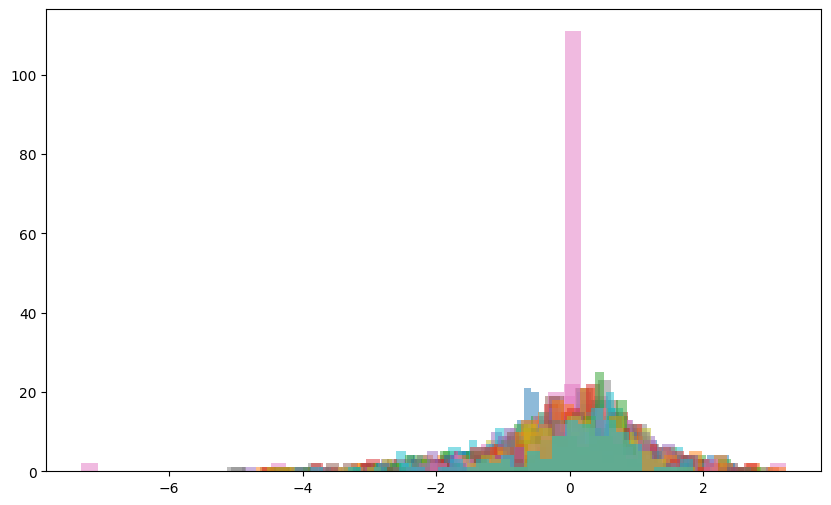

In [50]:
# import matplotlib.pyplot as plt

# # Select the first 100 columns
# subset = df_test_X.iloc[:, :100]

# plt.figure(figsize=(10,6))

# # Loop through each column and plot a histogram
# for column in subset:
#     plt.hist(subset[column], bins=30, alpha=0.5, label=str(column))

# # plt.legend(loc='upper right')
# plt.show()


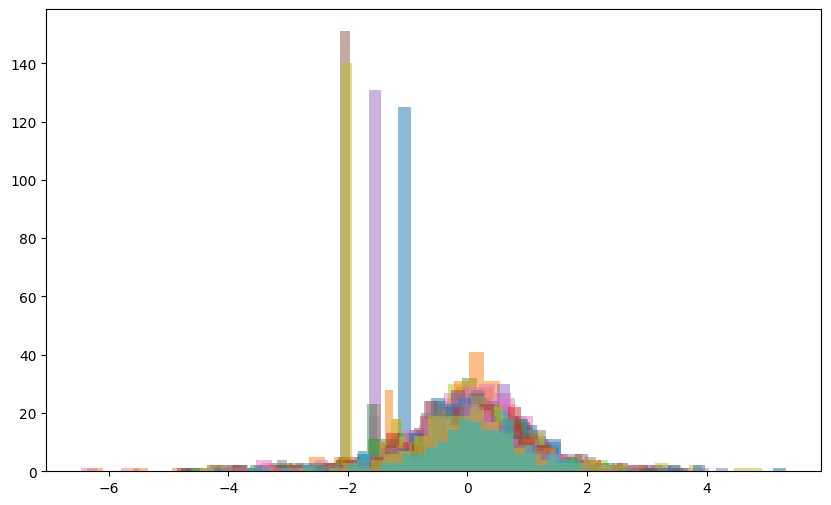

In [51]:
# import matplotlib.pyplot as plt

# # Select the first 100 columns
# subset = df_X.iloc[:, :100]

# plt.figure(figsize=(10,6))

# # Loop through each column and plot a histogram
# for column in subset:
#     plt.hist(subset[column], bins=30, alpha=0.5, label=str(column))

# # plt.legend(loc='upper right')
# plt.show()


In [101]:

# # Get the range of indices
# indices = np.arange(X.shape[0])

# # Split the data and indices
# X_train, X_test, y_train, y_test, train_indices, test_indices = train_test_split(
#     X, y, indices, test_size=0.2, stratify=y, random_state=0
# )

# # Get the patient IDs for the samples in X_test
# patient_ids_train = X_common.index[train_indices]
# patient_ids_test = X_common.index[test_indices]


In [ ]:
# Dataset 1 Labels A: Patients labeled by tumor GRADE
df_y = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_sample.txt", sep='\t', index_col=[0, 1])
# Dataset 1 Labels B: Patients labeled by tumor STAGE # Deprecated
# df_y = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_patient.txt", sep='\t', index_col=[0, 1])

# Dataset 2 Labels: Patients labeled by tumor GRADE
df_test_y = pd.read_csv('icgc-dataset-1695156575358/specimen.tsv', sep='\t')

# Update the class labels according to the binary or trinary label generation function
df_y['Neoplasm Histologic Grade'] = df_y['Neoplasm Histologic Grade'].apply(generate_binary_class_label) if two_class else df_y['Neoplasm Histologic Grade'].apply(generate_ternary_class_label)
df_test_y['tumour_grade'] = df_test_y['tumour_grade'].apply(generate_binary_class_label) if two_class else df_test_y['tumour_grade'].apply(generate_ternary_class_label)

# Remove patients that do not have a tumor grade assigned or are grade 4
df_y.dropna(subset=['Neoplasm Histologic Grade'], inplace=True)
df_test_y.dropna(subset=['tumour_grade'], inplace=True)

# Index by icgc_specimen_id
df_test_y.set_index('icgc_specimen_id', inplace=True)


'''


Clean data to keep only entries that have both mRNAseq and tumor grade


'''

# Keep only patient IDs with both mRNA sequence data AND tumor grade values
X_train_df_clean = df_X
y_train_df_clean = df_y['Neoplasm Histologic Grade']
X_test_df_clean = df_test_X
y_test_df_clean = df_test_y['tumour_grade']

print(f'Total number of patients in train dataset before removing patients without labels: {X_train_df_clean.shape[0]}')
print(f'Total number of labels in train dataset before removing labels without patients: {y_train_df_clean.shape[0]}')

print(f'Total number of patients in test dataset before removing patients without labels: {X_test_df_clean.shape[0]}')
print(f'Total number of labels in test dataset before removing labels without patients: {y_test_df_clean.shape[0]}')

# Filter X and y so they only include rows with common patients
# For train data
X_train_df_clean.index = X_train_df_clean.index.str.replace('-01', '')
common_ids = list(set(X_train_df_clean.index) & set(y_train_df_clean.index.get_level_values('#Patient Identifier')))
# print(len(common_ids))
X_train_df_clean = X_train_df_clean.loc[common_ids]
y_train_df_clean = y_train_df_clean.loc[y_train_df_clean.index.get_level_values('#Patient Identifier').isin(common_ids)]
# For test data

common_donor_ids = list(set(X_test_df_clean.index).intersection(set(y_test_df_clean.index)))

X_test_df_clean = X_test_df_clean.loc[common_donor_ids]
y_test_df_clean = y_test_df_clean.loc[common_donor_ids]


print(f'Total number of patients in train dataset after removing patients without labels: {X_train_df_clean.shape[0]}')
print(f'Total number of labels in train dataset after removing labels without patients: {y_train_df_clean.shape[0]}')

print(f'Total number of patients in test dataset after removing patients without labels: {X_test_df_clean.shape[0]}')
print(f'Total number of labels in test dataset after removing labels without patients: {y_test_df_clean.shape[0]}')

# Sort X and y by patient ID
# For train data
X_train_df_clean.sort_index(inplace=True)
y_train_df_clean.sort_index(inplace=True)
# For test data
X_test_df_clean.sort_index(inplace=True)
y_test_df_clean.sort_index(inplace=True)

# Convert X and y to arrays
X_train_clean = X_train_df_clean.values
y_train_clean = y_train_df_clean.values
X_test_clean = X_test_df_clean.values
y_test_clean = y_test_df_clean.values



In [ ]:
# # Dataset 1 Labels A: Patients labeled by tumor GRADE
# df_y = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_sample.txt", sep='\t', index_col=[0, 1])
# # Dataset 1 Labels B: Patients labeled by tumor STAGE # Deprecated
# # df_y = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_patient.txt", sep='\t', index_col=[0, 1])

# # Dataset 2 Labels: Patients labeled by tumor GRADE
# df_test_y = pd.read_csv('icgc-dataset-1689191752301/specimen.tsv', sep='\t')

# # Update the class labels according to the binary or trinary label generation function
# df_y['Neoplasm Histologic Grade'] = df_y['Neoplasm Histologic Grade'].apply(generate_binary_class_label) if two_class else df_y['Neoplasm Histologic Grade'].apply(generate_ternary_class_label)
# df_test_y['tumour_grade'] = df_test_y['tumour_grade'].apply(generate_binary_class_label) if two_class else df_test_y['tumour_grade'].apply(generate_ternary_class_label)

# # Remove patients that do not have a tumor grade assigned or are grade 4
# df_y.dropna(subset=['Neoplasm Histologic Grade'], inplace=True)
# df_test_y.dropna(subset=['tumour_grade'], inplace=True)

# # Index by icgc_specimen_id
# df_test_y.set_index('icgc_specimen_id', inplace=True)


# '''


# Clean data to keep only entries that have both mRNAseq and tumor grade


# '''

# # Keep only patient IDs with both mRNA sequence data AND tumor grade values
# X_train_df_clean = df_X
# y_train_df_clean = df_y['Neoplasm Histologic Grade']
# X_test_df_clean = df_test_X
# y_test_df_clean = df_test_y['tumour_grade']

# print(f'Total number of patients in train dataset before removing patients without labels: {X_train_df_clean.shape[0]}')
# print(f'Total number of labels in train dataset before removing labels without patients: {y_train_df_clean.shape[0]}')

# print(f'Total number of patients in test dataset before removing patients without labels: {X_test_df_clean.shape[0]}')
# print(f'Total number of labels in test dataset before removing labels without patients: {y_test_df_clean.shape[0]}')

# # Filter X and y so they only include rows with common patients
# # For train data
# X_train_df_clean.index = X_train_df_clean.index.str.replace('-01', '')
# common_ids = list(set(X_train_df_clean.index) & set(y_train_df_clean.index.get_level_values('#Patient Identifier')))
# # print(len(common_ids))
# X_train_df_clean = X_train_df_clean.loc[common_ids]
# y_train_df_clean = y_train_df_clean.loc[y_train_df_clean.index.get_level_values('#Patient Identifier').isin(common_ids)]
# # For test data

# common_donor_ids = list(set(X_test_df_clean.index).intersection(set(y_test_df_clean.index)))

# X_test_df_clean = X_test_df_clean.loc[common_donor_ids]
# y_test_df_clean = y_test_df_clean.loc[common_donor_ids]


# print(f'Total number of patients in train dataset after removing patients without labels: {X_train_df_clean.shape[0]}')
# print(f'Total number of labels in train dataset after removing labels without patients: {y_train_df_clean.shape[0]}')

# print(f'Total number of patients in test dataset after removing patients without labels: {X_test_df_clean.shape[0]}')
# print(f'Total number of labels in test dataset after removing labels without patients: {y_test_df_clean.shape[0]}')

# # Sort X and y by patient ID
# # For train data
# X_train_df_clean.sort_index(inplace=True)
# y_train_df_clean.sort_index(inplace=True)
# # For test data
# X_test_df_clean.sort_index(inplace=True)
# y_test_df_clean.sort_index(inplace=True)

# # Convert X and y to arrays
# X_train_clean = X_train_df_clean.values
# y_train_clean = y_train_df_clean.values
# X_test_clean = X_test_df_clean.values
# y_test_clean = y_test_df_clean.values



In [ ]:
print('\n')
print(f'There are {X_train.shape[1]} features in the training data.')

if use_lasso or use_rfe or use_rf or use_boruta:
    lasso_support_indices = []
    rfe_support_indices = []
    rf_support_indices = []
    boruta_support_indices = []
    
    # Use Lasso for feature reduction (only use features with non-zero coefficients)
    if use_lasso:
        lasso = LassoCV(cv=5).fit(X_train, y_train)
        coef = lasso.coef_
        important_features_indices = np.where(coef != 0)[0]
        X_lasso = X_train[:, important_features_indices]
        lasso_support_indices = np.where(lasso.coef_ != 0)[0]

        print('\n')
        print(f'Lasso regression selected {X_lasso.shape[1]} important features in the training data.')

    # Use Recursive Feature Elimination for feature reduction to a pre-set number of genes
    if use_rfe:
        model = LinearRegression()
        rfe = RFE(model, n_features_to_select=number_of_rfe_genes_to_keep)
        rfe.fit(X_train, y_train)
        X_rfe = X_train[:, rfe.support_]
        rfe_support_indices = np.where(rfe.support_)[0]

        print('\n')
        print(f'Recursive feature elimination (RFE) eliminated  all but {X_rfe.shape[1]} important features in the training data.')
    
    # Use Random Forest for feature reduction (select the n most important genes)
    if use_rf:
        rf = RandomForestClassifier(n_estimators=1000, random_state=1)
        rf.fit(X_train, y_train)

        # Get feature importances and calculate the cumulative sum
        importances = rf.feature_importances_
        cumsum_importances = np.cumsum(np.sort(importances)[::-1])

        # Get the indices that would sort the importances array
        sorted_indices = np.argsort(importances)[::-1]

        # Get the indices for the features that make up 50% of the importance
        total_rf_feature_importance=0.50
        rf_support_indices = sorted_indices[:np.where(cumsum_importances > total_rf_feature_importance)[0][0]]

        print(f'\nRandom Forest selected {len(rf_support_indices)} important features in the training data with total {total_rf_feature_importance*100}% feature importance.')
    
    # Use Boruta for feature reduction (select the n most important genes)
    if use_boruta:
        z_score_threshold = 0.99
        rf = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
        boruta_selector = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=1, perc=z_score_threshold)   
        boruta_selector.fit(X_train, y_train)

        boruta_support_indices = np.where(boruta_selector.support_)[0]

        print(f'\nBoruta selected {len(boruta_support_indices)} important features in the training data at {z_score_threshold} z-score threshold difference.')

    # Construct a list of arrays with indices of features selected by each method
    arrays = [x for x in (rfe_support_indices, lasso_support_indices, rf_support_indices, boruta_support_indices) if len(x) != 0]
    
    # Compute the common indices from all methods
    common_indices = reduce(np.intersect1d, arrays)
    
    print('\n')
    print(f'After feature reduction, {len(common_indices)} features remain in the training data (overlapping between multiple methods).')

    X_train = X_train[:, common_indices]
    X_test = X_test[:, common_indices]
    print('\n')
    print(f'X_train and X_test now have {X_train.shape[1]} features each from the feature reduction.')

# Use PCA to extract relevant features from the dataset
if use_PCA:
    pca = PCA(n_components=number_of_PCA_components)
    X_train = pca.fit_transform(X_train)
    X_test = pca.transform(X_test)

if use_PCA:
    print(f'There are {X_train.shape[1]} features in the training data after PCA.')

print('\n')
print(f'There are {round(y_train.sum()/len(y_train)*100)}% positive examples of out {len(y_train)} in the training data.')
print(f'There are {round(y_test.sum()/len(y_test)*100)}% positive examples of out {len(y_test)} in the test data.')

# Save the X-train and y-train varaiables for train dataset surival curves below
X_train_no_SMOTE = X_train
y_train_no_SMOTE = y_train

# Instantiate the SMOTE algorithm and resample the data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

print('\n')
print(f'After SMOTE there are {round(y_train.sum()/len(y_train)*100)}% positive examples in the training data.')


In [6]:
if use_lasso or use_rfe or use_rf or use_boruta:
    top_common_genes = [X_train_df.columns[i] for i in common_indices]
    print(f'Remaining genes after feature reduction')
    print(top_common_genes)
    top_common_genes = [(gene, int(count)) for gene, count in top_common_genes]
    with open(f'Best remaining {len(top_common_genes)} genes.json', 'w') as f:
        json.dump(top_common_genes, f)

Remaining genes after feature reduction
[('ARMC10', 83787), ('CLDN11', 5010), ('DERL2', 51009), ('DNASE1L1', 1774), ('HLA-C', 3107), ('LRRC42', 115353), ('RHEBL1', 121268)]


In [7]:
'''

NOTE: Logistic Regression with l2 regularization is returning an accuracy of 50%
which means that it is just guessing. So we will not continue with this model

'''

'\n\nNOTE: Logistic Regression with l2 regularization is returning an accuracy of 50%\nwhich means that it is just guessing. So we will not continue with this model\n\n'

In [8]:
# Define the class labels
if three_class:
    class_labels = ['Grade I', 'Grade II', 'Grade III']
elif two_class:
    class_labels = ['Grade I', 'Grade II/III']


def plot_confusion_matrix(conf_matrix_sum, class_labels):
    # Calculate the percentage of each value in the confusion matrix by column
    percentage_matrix = conf_matrix_sum / conf_matrix_sum.sum(axis=0, keepdims=True) * 100

    # Calculate sensitivity, specificity, and F1 score
    sensitivity = np.diag(conf_matrix_sum) / np.sum(conf_matrix_sum, axis=1)
    specificity = np.diag(conf_matrix_sum) / np.sum(conf_matrix_sum, axis=0)
    f1_scores = 2 * (sensitivity * specificity) / (sensitivity + specificity)

    # Create a custom function to display both the count and the percentage in the heatmap
    def display_count_percentage(matrix, count_matrix, percentage_matrix):
        for y in range(matrix.shape[0]):
            for x in range(matrix.shape[1]):
                c = count_matrix[y, x]
                p = percentage_matrix[y, x]
                matrix[y, x] = f'{c}\n({p:.1f}%)'

    # Combine count and percentage in a single matrix
    combined_matrix = np.empty(conf_matrix_sum.shape, dtype=object)
    display_count_percentage(combined_matrix, conf_matrix_sum, percentage_matrix)

    # Plot the heatmap with count and percentage
    plt.figure(figsize=(8, 6))
    sns.heatmap(percentage_matrix, annot=combined_matrix, fmt='', cmap='Blues', cbar=False, xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted")
    plt.ylabel("True")
    plt.title("Confusion Matrix")

    # Display sensitivity, specificity, and F1 score
    for i, label in enumerate(class_labels):
        plt.text(len(class_labels) + 0.5, i + 0.5, f'Sensitivity: {sensitivity[i]:.2f}\nSpecificity: {specificity[i]:.2f}\nF1 Score: {f1_scores[i]:.2f}',
                 va='center', ha='left', fontsize=12, fontweight='bold')

    plt.show()

In [10]:
def bootstrap_nested_repeated_cv(model, params_ranges, X, y, X_test, y_test, num_bootstrap_iterations, num_repeats, num_splits):
    param_scores = defaultdict(list)
    nested_cv_scores = []
    nested_conf_matrix = []
    nested_f1_score = []
    nested_importances = np.zeros((1, X.shape[1]))
    bootstrap_accuracy = []
    bootstrap_conf_matrix = []
    bootstrap_f1_score = []
    random_seed = 0

    # Bootstrap iterations
    for i in tqdm(range(num_bootstrap_iterations),'Bootstrapping...'):
        # Resample the data with replacement to form a new dataset
        X_resampled, y_resampled = resample(X, y, random_state=i)
        best_score = 0
        best_params = None
        best_model = None
        
        # Nested cross-validation
        for param_set in params_ranges:
            inner_scores = []
            for i in range(num_repeats):
                # Update the kf with the current random_seed
                kf = KFold(n_splits=num_splits, shuffle=True, random_state=random_seed)
                # Update the random seed so that there is a new split on every run
                random_seed += 1
                for train_index, test_index in kf.split(X_resampled):
                    X_train, X_val = X_resampled[train_index], X_resampled[test_index]
                    y_train, y_val = y_resampled[train_index], y_resampled[test_index]

                    model.set_params(**param_set)
                    model.fit(X_train, y_train)

                    score = model.score(X_val, y_val)
                    nested_cv_scores.append(score)

                    if hasattr(model, 'feature_importances_'):
                        importances = model.feature_importances_
                        nested_importances += importances

                    y_pred = model.predict(X_val)

                    conf_matrix = confusion_matrix(y_val, y_pred)
                    nested_conf_matrix.append(conf_matrix)

                    # Compute F1-score
                    f1 = f1_score(y_val, y_pred, average='weighted')
                    nested_f1_score.append(f1)

                    inner_scores.append(f1)

            # Keep track of the best model, params and score within each bootstrap iteration
            mean_score = np.mean(inner_scores)
            if mean_score > best_score:
                best_score = mean_score
                best_params = param_set
                best_model = model
                
            param_scores[str(param_set)].append(mean_score)

        # At the end of each bootstrap iteration, evaluate the best model on the test set
        y_pred_test = best_model.predict(X_test)

        accuracy_test = accuracy_score(y_test, y_pred_test)
        conf_matrix_test = confusion_matrix(y_test, y_pred_test)
        f1_test = f1_score(y_test, y_pred_test, average='weighted')

        bootstrap_accuracy.append(accuracy_test)
        bootstrap_conf_matrix.append(conf_matrix_test)
        bootstrap_f1_score.append(f1_test)

    # Get the best parameter set based on average score across all bootstrap iterations
    best_params_overall = max(param_scores, key=lambda k: np.mean(param_scores[k]))
    best_score_overall = np.mean(param_scores[best_params_overall])

    # Train the final model with the best parameters on the entire dataset
    best_model_overall = model.set_params(**eval(best_params_overall))
    best_model_overall.fit(np.concatenate((X, X_test)), np.concatenate((y, y_test)))

    return best_model_overall, best_params_overall, best_score_overall, nested_cv_scores, nested_conf_matrix, nested_f1_score, nested_importances, bootstrap_accuracy, bootstrap_conf_matrix, bootstrap_f1_score

# K-Nearest Neighbors
print('K-Nearest Neighbors')
knn_params_ranges = [{'n_neighbors': n, 'weights': w} for n in [1, 3, 5, 7, 9] for w in ['uniform', 'distance']]
(
    best_knn_model_overall, 
    best_knn_params_overall, 
    best_knn_score_overall, 
    knn_nested_cv_scores, 
    knn_nested_conf_matrix, 
    knn_nested_f1_score, _, 
    knn_bootstrap_accuracy, 
    knn_bootstrap_conf_matrix, 
    knn_bootstrap_f1_score
) = bootstrap_nested_repeated_cv(
    KNeighborsClassifier(), 
    knn_params_ranges, 
    X_train, y_train, 
    X_test, y_test, 
    num_bootstrap_iterations, 
    num_repeats, 
    num_splits
)

# Random Forest
print('Random Forest')
rf_params_ranges = [{'n_estimators': n, 'max_depth': d} for n in [10, 50, 100, 200, 500] for d in [3, 6, 10, 15]]
(
    best_rf_model_overall, 
    best_rf_params_overall, 
    best_rf_score_overall, 
    rf_nested_cv_scores, 
    rf_nested_conf_matrix, 
    rf_nested_f1_score, 
    rf_nested_importances, 
    rf_bootstrap_accuracy, 
    rf_bootstrap_conf_matrix, 
    rf_bootstrap_f1_score
) = bootstrap_nested_repeated_cv(
    RandomForestClassifier(), 
    rf_params_ranges, 
    X_train, y_train, 
    X_test, y_test, 
    num_bootstrap_iterations, 
    num_repeats, 
    num_splits
)

# SVM
print('SVM')
# k in ['linear', 'rbf', 'sigmoid']
svm_params_ranges = [{'kernel': k, 'C': c, 'gamma': g} for k in ['linear'] for c in np.logspace(-3, 3, 5) for g in np.logspace(-3, 3, 5)]
(
    best_svm_model_overall, 
    best_svm_params_overall, 
    best_svm_score_overall, 
    svm_nested_cv_scores, 
    svm_nested_conf_matrix, 
    svm_nested_f1_score, _, 
    svm_bootstrap_accuracy, 
    svm_bootstrap_conf_matrix, 
    svm_bootstrap_f1_score
) = bootstrap_nested_repeated_cv(
    svm.SVC(max_iter=1000), 
    svm_params_ranges, 
    X_train, y_train, 
    X_test, y_test, 
    num_bootstrap_iterations, 
    num_repeats, 
    num_splits
)


K-Nearest Neighbors


Bootstrapping...: 100%|███████████████████████| 100/100 [00:43<00:00,  2.30it/s]


Random Forest


Bootstrapping...: 100%|█████████████████████| 100/100 [1:15:27<00:00, 45.28s/it]


SVM


Bootstrapping...:   0%|                                 | 0/100 [00:00<?, ?it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:   2%|▌                        | 2/100 [00:01<01:26,  1.13it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:   4%|█                        | 4/100 [00:03<01:22,  1.16it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:   6%|█▌                       | 6/100 [00:05<01:19,  1.18it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:   8%|██                       | 8/100 [00:06<01:16,  1.20it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  10%|██▍                     | 10/100 [00:08<01:14,  1.21it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  12%|██▉                     | 12/100 [00:10<01:15,  1.16it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  14%|███▎                    | 14/100 [00:11<01:14,  1.15it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  16%|███▊                    | 16/100 [00:13<01:11,  1.17it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  18%|████▎                   | 18/100 [00:15<01:08,  1.19it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  20%|████▊                   | 20/100 [00:16<01:06,  1.21it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  22%|█████▎                  | 22/100 [00:18<01:10,  1.11it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  24%|█████▊                  | 24/100 [00:20<01:09,  1.09it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  27%|██████▍                 | 27/100 [00:23<01:13,  1.01s/it]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  29%|██████▉                 | 29/100 [00:25<01:08,  1.04it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  31%|███████▍                | 31/100 [00:27<01:07,  1.02it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  36%|████████▋               | 36/100 [00:33<01:07,  1.05s/it]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  38%|█████████               | 38/100 [00:34<01:02,  1.00s/it]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  40%|█████████▌              | 40/100 [00:36<00:56,  1.06it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  42%|██████████              | 42/100 [00:38<00:51,  1.12it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  44%|██████████▌             | 44/100 [00:40<00:50,  1.11it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  46%|███████████             | 46/100 [00:42<00:50,  1.07it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  48%|███████████▌            | 48/100 [00:44<00:52,  1.01s/it]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  50%|████████████            | 50/100 [00:46<00:49,  1.01it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  52%|████████████▍           | 52/100 [00:48<00:46,  1.03it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  54%|████████████▉           | 54/100 [00:49<00:43,  1.05it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  56%|█████████████▍          | 56/100 [00:51<00:41,  1.07it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  58%|█████████████▉          | 58/100 [00:53<00:39,  1.06it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  60%|██████████████▍         | 60/100 [00:55<00:35,  1.11it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  62%|██████████████▉         | 62/100 [00:57<00:34,  1.10it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  64%|███████████████▎        | 64/100 [00:58<00:31,  1.16it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  66%|███████████████▊        | 66/100 [01:00<00:29,  1.15it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  68%|████████████████▎       | 68/100 [01:02<00:28,  1.11it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  70%|████████████████▊       | 70/100 [01:04<00:27,  1.08it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  72%|█████████████████▎      | 72/100 [01:06<00:26,  1.06it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  74%|█████████████████▊      | 74/100 [01:08<00:23,  1.12it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  76%|██████████████████▏     | 76/100 [01:09<00:20,  1.15it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  79%|██████████████████▉     | 79/100 [01:12<00:20,  1.04it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  82%|███████████████████▋    | 82/100 [01:16<00:20,  1.15s/it]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  84%|████████████████████▏   | 84/100 [01:18<00:17,  1.07s/it]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  86%|████████████████████▋   | 86/100 [01:19<00:12,  1.09it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  89%|█████████████████████▎  | 89/100 [01:22<00:08,  1.28it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  90%|█████████████████████▌  | 90/100 [01:25<00:15,  1.56s/it]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  92%|██████████████████████  | 92/100 [01:27<00:10,  1.33s/it]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  94%|██████████████████████▌ | 94/100 [01:29<00:06,  1.10s/it]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  96%|███████████████████████ | 96/100 [01:30<00:03,  1.10it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  97%|███████████████████████▎| 97/100 [01:31<00:02,  1.18it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...:  99%|███████████████████████▊| 99/100 [01:33<00:00,  1.31it/s]/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data wi

/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/Users/DanielFu/miniconda3/e

Bootstrapping...: 100%|███████████████████████| 100/100 [01:33<00:00,  1.07it/s]
/Users/DanielFu/miniconda3/envs/zambir/lib/python3.9/site-packages/sklearn/svm/_base.py:297: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


In [11]:
print("Best KNN params:", best_knn_params_overall, "Best CV score:", best_knn_score_overall)
print("Best RF params:", best_rf_params_overall, "Best CV score:", best_rf_score_overall)
print("Best SVM params:", best_svm_params_overall, "Best CV score:", best_svm_score_overall)


Best KNN params: {'n_neighbors': 1, 'weights': 'distance'} Best CV score: 0.9668515339510708
Best RF params: {'n_estimators': 500, 'max_depth': 10} Best CV score: 0.9657003007254841
Best SVM params: {'kernel': 'linear', 'C': 31.622776601683793, 'gamma': 0.1778279410038923} Best CV score: 0.90352326561661


In [12]:
# '''
# Get a list of genes sorted by feature importance
# '''
# num_most_important_features = 50
# indices_of_top_n_highest_rf_importances = np.argsort(nested_importances[0])[-num_most_important_features:][::-1]

# # get the corresponding Hugo_Symbol and Entrez_Gene_Id for each index
# top_n_genes = [X_common.columns[i] for i in indices_of_top_n_highest_rf_importances]
# sorted_feature_importances = np.sort(nested_importances[0], kind='quicksort', order=None)[::-1][:num_most_important_features]

# print('top n genes with feature_importances')
# top_n_genes_with_feature_importances = [{'Gene ID':(gene[0],int(gene[1])), 'Importance':round(fi,2)} for gene, fi in zip(top_n_genes, sorted_feature_importances)]
# print(top_n_genes_with_feature_importances)

# total_importance_captured = sum(sorted_feature_importances)/sum(nested_importances[0])
# print(f'Total Importance Captured is {100*total_importance_captured:.2f}%')

# with open(f'Top {num_most_important_features} genes with importance.json', 'w') as f:
#     json.dump(top_n_genes_with_feature_importances, f)

# # Visualize nested cross-validation results
# nested_cv_scores = knn_nested_cv_scores + rf_nested_cv_scores + svm_nested_cv_scores
# #Create a running average
# nested_cv_scores = [sum(nested_cv_scores[:i+1]) / (i+1) for i in range(len(nested_cv_scores))]
# plt.plot(range(1, len(nested_cv_scores) + 1), nested_cv_scores, marker='o', linestyle='--')
# plt.xlabel('Fold')
# plt.ylabel('Score')
# plt.title('Nested Cross-Validation Running Average Accuracy')
# plt.show()

# # Visualize nested cross-validation results
# nested_conf_matrix = knn_nested_conf_matrix + rf_nested_conf_matrix + svm_nested_conf_matrix
# #Create a running average
# # nested_conf_matrix = [sum(nested_conf_matrix[:i+1]) / (i+1) for i in range(len(nested_conf_matrix))]
# # Plot the confusion matrix
# plot_confusion_matrix(sum(nested_conf_matrix),class_labels)

# # Visualize nested cross-validation results
# nested_f1_score = knn_nested_f1_score + rf_nested_f1_score + svm_nested_f1_score
# #Create a running average
# nested_f1_score = [sum(nested_f1_score[:i+1]) / (i+1) for i in range(len(nested_f1_score))]
# plt.plot(range(1, len(nested_f1_score) + 1), nested_f1_score, marker='o', linestyle='--')
# plt.xlabel('Fold')
# plt.ylabel('Score')
# plt.title('Nested Cross-Validation Running Average F1-Score')
# plt.show()

In [13]:
# Compute CI

def compute_CI(array_of_values):
    # Compute sample statistics
    mean = np.mean(array_of_values)
    std_dev = np.std(array_of_values, ddof=1)  # ddof=1 computes sample standard deviation
    n = len(array_of_values)

    # Compute the standard error and the 95% Confidence Interval
    se = std_dev / np.sqrt(n)
    ci = stats.t.interval(confidence=0.95, df=n-1, loc=mean, scale=se)

    print(f"The 95% Confidence Interval is {ci}")
    return ci


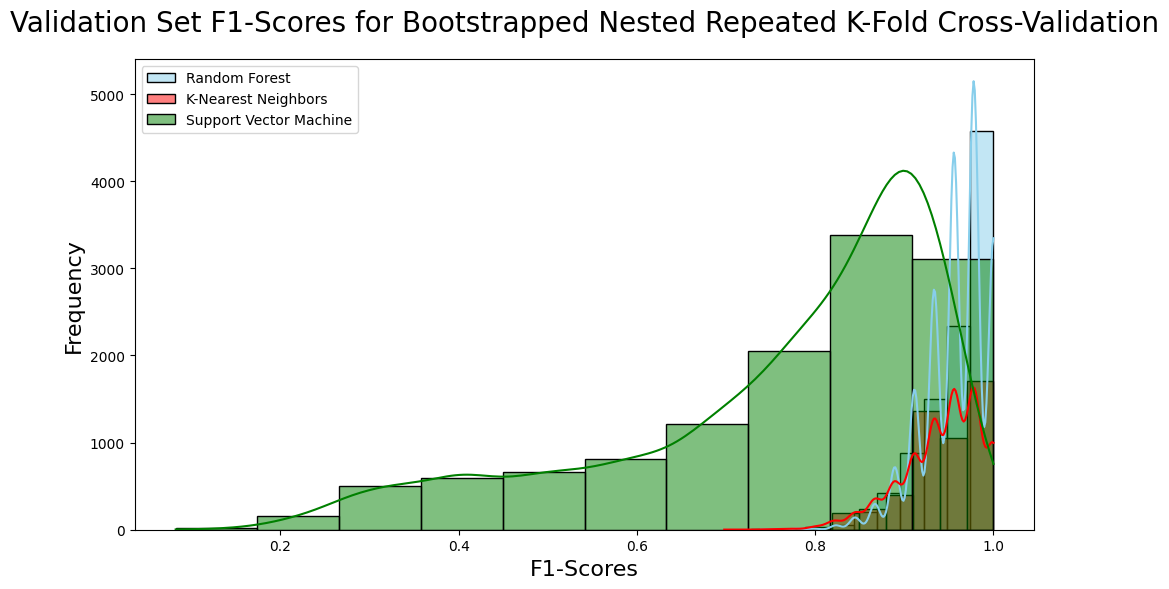

In [14]:
# Create the histogram
plt.figure(figsize=(10, 6))
sns.histplot(rf_nested_f1_score, bins=10, kde=True, color='skyblue', label='Random Forest')
sns.histplot(knn_nested_f1_score, bins=10, kde=True, color='red', label='K-Nearest Neighbors')
sns.histplot(svm_nested_f1_score, bins=10, kde=True, color='green', label='Support Vector Machine')

# Set the title and labels with larger font
plt.title("Validation Set F1-Scores for Bootstrapped Nested Repeated K-Fold Cross-Validation", fontsize=20, pad=20)
plt.xlabel("F1-Scores", fontsize=16)
plt.ylabel("Frequency", fontsize=16)
plt.legend()

# Display the plot with sufficient space for the title
plt.tight_layout()
plt.show()

In [15]:
compute_CI(rf_nested_f1_score)

The 95% Confidence Interval is (0.9561362298398224, 0.9575227697069604)


(0.9561362298398224, 0.9575227697069604)

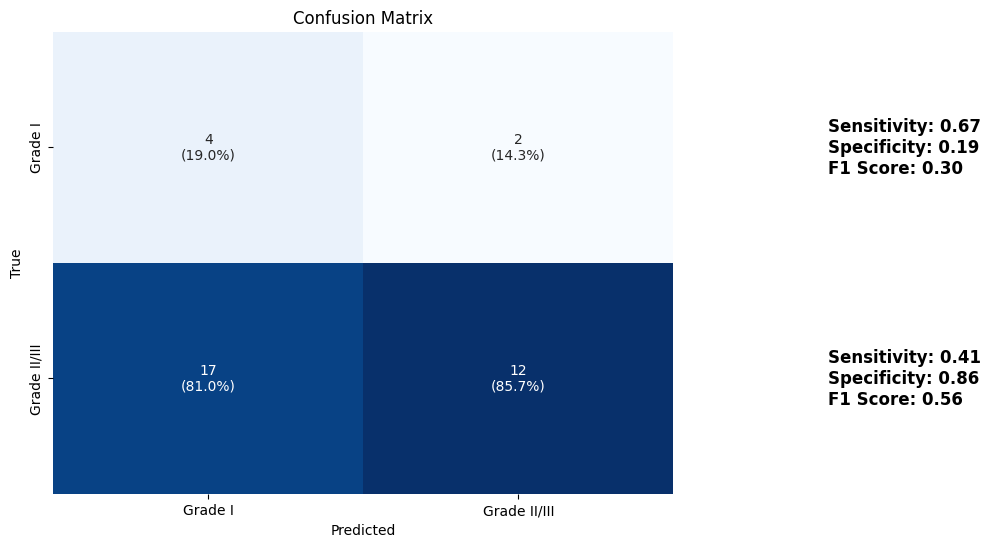

Control Model Confusion Matrix:
[[ 4  2]
 [17 12]]
Control Model Accuracy: 0.4571
Control Model Sensitivity: [0.66666667 0.4137931 ]
Control Model Specificity: [0.19047619 0.85714286]
Control Model F1 Score: 0.5133



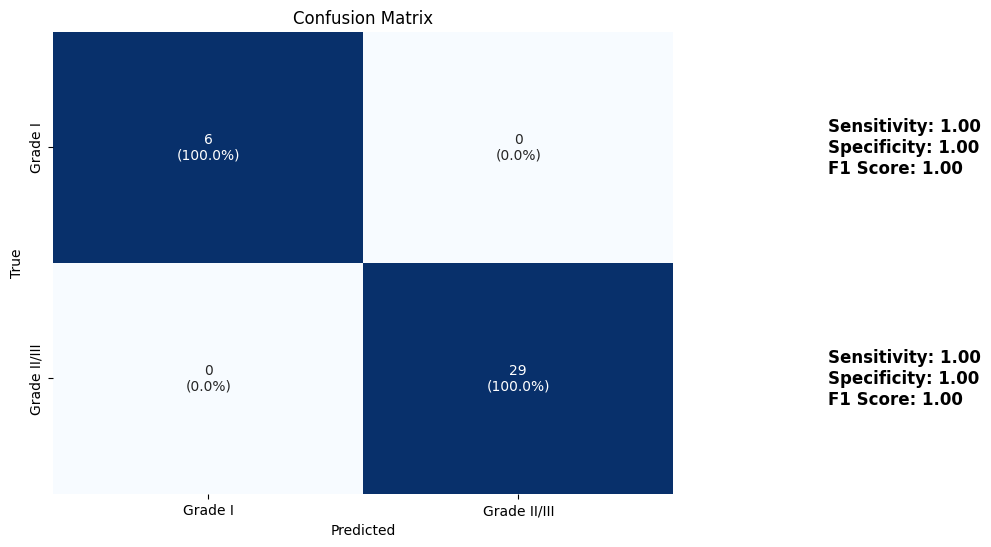

KNN Confusion Matrix:
[[ 6  0]
 [ 0 29]]
KNN Accuracy: 1.0000
KNN Sensitivity: [1. 1.]
KNN Specificity: [1. 1.]
KNN F1 Score: 1.0000



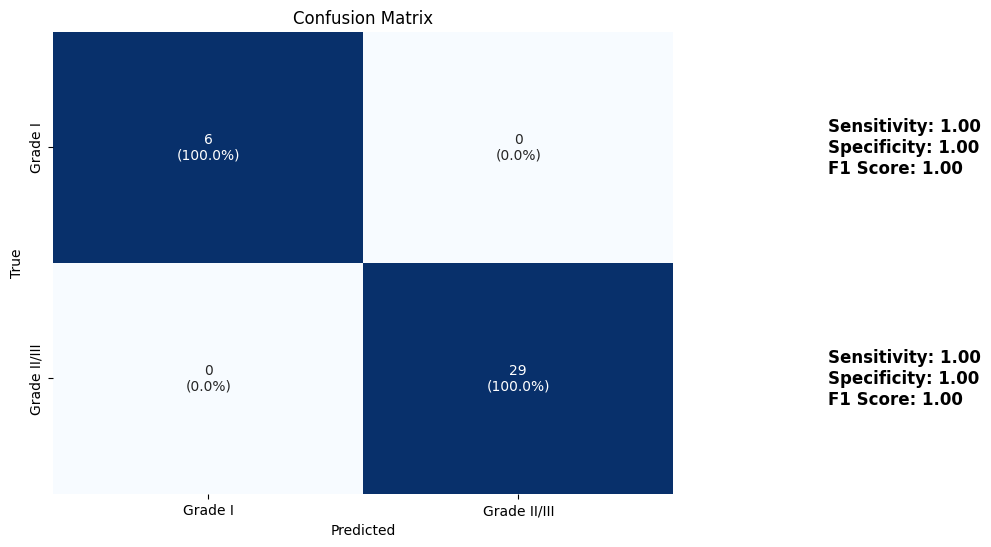

Random Forest Confusion Matrix:
[[ 6  0]
 [ 0 29]]
Random Forest Accuracy: 1.0000
Random Forest Sensitivity: [1. 1.]
Random Forest Specificity: [1. 1.]
Random Forest F1 Score: 1.0000



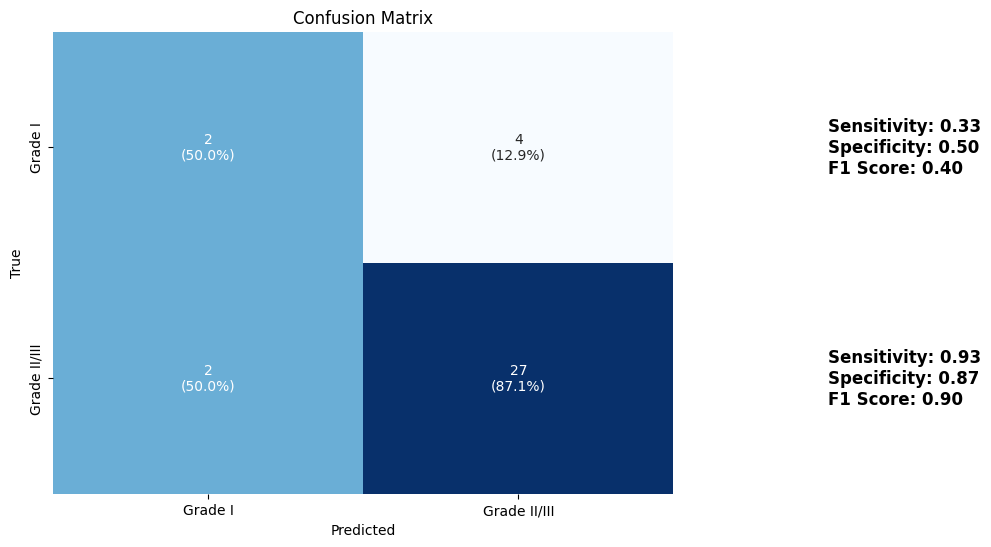

SVM Confusion Matrix:
[[ 2  4]
 [ 2 27]]
SVM Accuracy: 0.8286
SVM Sensitivity: [0.33333333 0.93103448]
SVM Specificity: [0.5        0.87096774]
SVM F1 Score: 0.8143



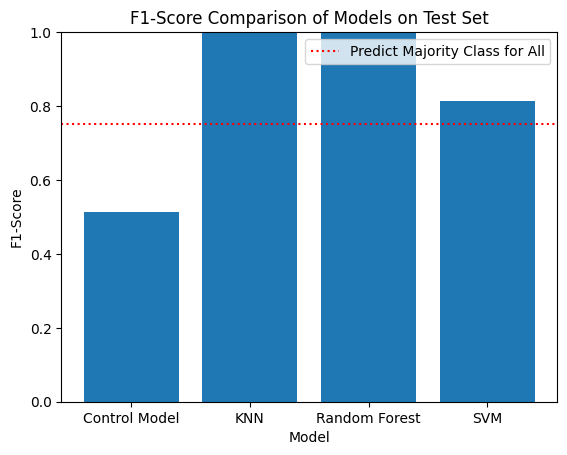

In [18]:
print('Results of the best overall model performance on held-out test set amongst all param sets for average F1-score using bootstrapped nested repeated cross-validation sets')

# Train the control model and compare results to other models

# Find the single most important feature
# Here, we'll use the absolute correlation between each feature and the target variable as the measure of importance
feature_importance = np.abs(np.corrcoef(X_train.T, y_train)[0, 1:])
most_important_feature_index = np.argmax(feature_importance)
y_pred = np.zeros(len(X_test))

# Train the control model
# The model will simply predict the class based on the value of the most important feature
if two_class:
    threshold = np.median(X_train[:, most_important_feature_index])
    y_pred[X_test[:, most_important_feature_index] > threshold] = 0
    y_pred[X_test[:, most_important_feature_index] <= threshold] = 1

if three_class:
    # Find the thresholds for separating the three classes
    threshold1 = np.percentile(X_train[:, most_important_feature_index], 33)
    threshold2 = np.percentile(X_train[:, most_important_feature_index], 67)
    y_pred[X_test[:, most_important_feature_index] <= threshold1] = 0
    y_pred[(X_test[:, most_important_feature_index] > threshold1) & (X_test[:, most_important_feature_index] <= threshold2)] = 1
    y_pred[X_test[:, most_important_feature_index] > threshold2] = 2

y_pred_majority = np.ones(len(X_test))
f1_majority = f1_score(y_test, y_pred_majority, average='weighted')

models = {
    'Control Model': y_pred,
    'KNN': best_knn_model_overall,
    'Random Forest': best_rf_model_overall,
    'SVM': best_svm_model_overall
}

f1_scores = []

for model_name, model in models.items():
    if model_name == 'Control Model':
        y_pred = model
    else:
        y_pred = model.predict(X_test)
        
    # Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    
    conf_matrix = confusion_matrix(y_test, y_pred)
    plot_confusion_matrix(np.array(conf_matrix),class_labels)

    # Calculate Sensitivity and Specificity
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    specificity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{model_name} Confusion Matrix:\n{conf_matrix}")
    print(f"{model_name} Accuracy: {accuracy:.4f}")
    print(f"{model_name} Sensitivity: {sensitivity}")
    print(f"{model_name} Specificity: {specificity}")
    print(f"{model_name} F1 Score: {f1:.4f}\n")

    f1_scores.append((model_name, f1))

# Sort models by F1 score
f1_scores.sort(key=lambda x: x[1], reverse=True)

# Move the control model to the left
control_model = f1_scores.pop()
f1_scores.insert(0, control_model)

# Create bar plot
labels, scores = zip(*f1_scores)
plt.bar(labels, scores)
plt.xlabel('Model')
plt.ylabel('F1-Score')
plt.title('F1-Score Comparison of Models on Test Set')
plt.xticks(fontsize=10)
plt.axhline(y=f1_majority, color='red', linestyle='dotted', label='Predict Majority Class for All')
plt.legend()
plt.ylim([0,1])
plt.show()


The 95% Confidence Interval is (0.5086222187448152, 0.52605232731507)
The 95% Confidence Interval is (0.7479014029561944, 0.7567525854391469)
The 95% Confidence Interval is (0.7756388345903495, 0.7855894614203369)
The 95% Confidence Interval is (0.6919180722720981, 0.7236135080216988)


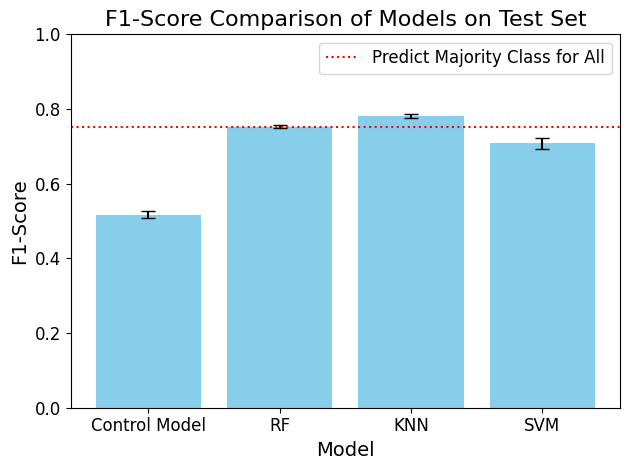

In [19]:
print(f'{num_bootstrap_iterations}-fold Bootstrapped nested repeated cross validation F1-scores with confidence intervals on held-out test set')

f1_scores = []

control_f1s = []
# Train the control model and compare results to other models
for i in range(num_bootstrap_iterations):
    # Resample the data with replacement to form a new dataset
    X_resampled, y_resampled = resample(X_train, y_train, random_state=i)
    # Find the single most important feature
    # Here, we'll use the absolute correlation between each feature and the target variable as the measure of importance
    feature_importance = np.abs(np.corrcoef(X_resampled.T, y_resampled)[0, 1:])
    most_important_feature_index = np.argmax(feature_importance)
    y_pred = np.zeros(len(X_test))

    # Train the control model
    # The model will simply predict the class based on the value of the most important feature
    if two_class:
        threshold = np.median(X_resampled[:, most_important_feature_index])
        y_pred[X_test[:, most_important_feature_index] > threshold] = 0
        y_pred[X_test[:, most_important_feature_index] <= threshold] = 1

    if three_class:
        # Find the thresholds for separating the three classes
        threshold1 = np.percentile(X_resampled[:, most_important_feature_index], 33)
        threshold2 = np.percentile(X_resampled[:, most_important_feature_index], 67)
        y_pred[X_test[:, most_important_feature_index] <= threshold1] = 0
        y_pred[(X_test[:, most_important_feature_index] > threshold1) & (X_test[:, most_important_feature_index] <= threshold2)] = 1
        y_pred[X_test[:, most_important_feature_index] > threshold2] = 2

    models = {
        'Control Model': y_pred,
        'KNN': best_knn_model_overall,
        'Random Forest': best_rf_model_overall,
        'SVM': best_svm_model_overall
    }

    # Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)

    conf_matrix = confusion_matrix(y_test, y_pred)

    # Calculate Sensitivity and Specificity
    sensitivity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=1)
    specificity = np.diag(conf_matrix) / np.sum(conf_matrix, axis=0)
    f1 = f1_score(y_test, y_pred, average='weighted')

    control_f1s.append(f1)

control_CI = compute_CI(control_f1s)
rf_CI = compute_CI(rf_bootstrap_f1_score)
knn_CI = compute_CI(knn_bootstrap_f1_score)
svm_CI = compute_CI(svm_bootstrap_f1_score)  
    
f1_scores.append(('Control Model', np.mean(control_f1s), control_CI))
f1_scores.append(('RF', np.mean(rf_bootstrap_f1_score), rf_CI))
f1_scores.append(('KNN', np.mean(knn_bootstrap_f1_score), knn_CI))
f1_scores.append(('SVM', np.mean(svm_bootstrap_f1_score), svm_CI))

y_pred_majority = np.ones(len(X_test))
f1_majority = f1_score(y_test, y_pred_majority, average='weighted')

# Move the control model to the left
# control_model = f1_scores.pop()
# f1_scores.insert(0, control_model)

# Sort models by F1 score
# f1_scores.sort(key=lambda x: x[1], reverse=True)

# Create bar plot
labels, scores, CIs = zip(*f1_scores)
lower_bounds, upper_bounds = zip(*CIs)
# Calculate error bars
y_err_lower = [score - lb for score, lb in zip(scores, lower_bounds)]
y_err_upper = [ub - score for score, ub in zip(scores, upper_bounds)]
plt.bar(labels, scores, yerr=[y_err_lower, y_err_upper], capsize=5, color='skyblue', ecolor='black')
plt.xlabel('Model', fontsize=14)
plt.ylabel('F1-Score', fontsize=14)
plt.title('F1-Score Comparison of Models on Test Set', fontsize=16)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.axhline(y=f1_majority, color='red', linestyle='dotted', label='Predict Majority Class for All')
plt.legend(fontsize=12)
plt.ylim([0,1])
plt.tight_layout()
plt.show()


In [20]:
# Visualize class boundaries using PCA
if use_PCA:
    colors = ['blue', 'red', 'green']
    markers = ['s', 'x', 'o']
    for l, c, m in zip(np.unique(y_train), colors, markers):
        if three_class:
            if l == 0:
                grade = 'Grade I'
            elif l == 1:
                grade = 'Grade II'
            else:
                grade = 'Grade III'
        elif two_class:
            if l == 0:
                grade = 'Grade I'
            elif l == 1:
                grade = 'Grade II/III'
        plt.scatter(X_train[y_train == l, 0], X_train[y_train == l, 1], c=c, label=grade, marker=m)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best')
    plt.title('Low-dimensional Visualization of Class Boundaries using PCA in Train Data')
    plt.show()

    colors = ['blue', 'red', 'green']
    markers = ['s', 'x', 'o']
    for l, c, m in zip(np.unique(y_test), colors, markers):
        if three_class:
            if l == 0:
                grade = 'Grade I'
            elif l == 1:
                grade = 'Grade II'
            else:
                grade = 'Grade III'
        elif two_class:
            if l == 0:
                grade = 'Grade I'
            elif l == 1:
                grade = 'Grade II/III'
        plt.scatter(X_test[y_test == l, 0], X_test[y_test == l, 1], c=c, label=grade, marker=m)

    plt.xlabel('Principal Component 1')
    plt.ylabel('Principal Component 2')
    plt.legend(loc='best')
    plt.title('Low-dimensional Visualization of Class Boundaries using PCA in Test Data')
    plt.show()


In [21]:
from matplotlib.lines import Line2D

if use_PCA and number_of_PCA_components == 2:
    models = {
        'KNN': knn_model,
        'Random Forest': rf_model,
        'SVM': svm_model,
        'Logistic Regression': lr_model
    }

    # Create a mesh grid for plotting decision boundaries
    x_min, x_max = X_test[:, 0].min() - 1, X_test[:, 0].max() + 1
    y_min, y_max = X_test[:, 1].min() - 1, X_test[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.1), np.arange(y_min, y_max, 0.1))

    # Create a 3x1 grid of subplots
    fig, axarr = plt.subplots(2, 2, figsize=(10, 10))
    axarr = axarr.flatten()
    
    colors = np.array(['blue', 'red'])
    markers = np.array(['s', 'x'])

    for idx, (name, model) in enumerate(models.items()):
        if name == 'Logistic Regression':
            y_logit = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32)).detach().numpy()
            y_prob = 1 / (1 + np.exp(-y_logit))
            y_pred = np.where(y_prob[:, 0] > 0.5, 1, 0)
            Z = y_pred.reshape(xx.shape)
        else:
            # Fit the model and predict on the mesh grid
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)

        # Plot the decision boundaries
        axarr[idx].contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.coolwarm)
        for i in range(len(X_test.tolist())):
            axarr[idx].scatter(X_test[i, 0], X_test[i, 1], c=colors[y_test.astype(int)][i], marker=markers[y_test.astype(int)][i])
        axarr[idx].set_xlabel('Feature 1')
        axarr[idx].set_ylabel('Feature 2')
        axarr[idx].set_title(name)

    # Add the legend
    legend_elements = [Line2D([0], [0], marker='s', color='w', label='Grade I', markerfacecolor='blue', markersize=10),
                       Line2D([0], [0], marker='x', color='w', label='Grade II/III', markerfacecolor='red', markersize=10)]
    plt.legend(handles=legend_elements, loc='lower right')

    plt.tight_layout()
    plt.show()


In [22]:
# Create a function to format the table
def render_mpl_table(data, col_width=3, row_height=0.625, font_size=12,
                     header_color='#40466e', row_colors=['#f1f1f2', 'w'], edge_color='w',
                     bbox=[0, 0, 1, 1], header_columns=0, ax=None, table_title=None, **kwargs):
    if ax is None:
        size = (np.array(data.shape[::-1]) + np.array([0, 1])) * np.array([col_width, row_height])
        fig, ax = plt.subplots(figsize=size)
        ax.axis('off')

    mpl_table = ax.table(cellText=data.values, bbox=bbox, colLabels=data.columns, **kwargs)

    mpl_table.auto_set_font_size(False)
    mpl_table.set_fontsize(font_size)

    for k, cell in mpl_table._cells.items():
        cell.set_edgecolor(edge_color)
        if k[0] == 0 or k[1] < header_columns:
            cell.set_text_props(weight='bold', color='w')
            cell.set_facecolor(header_color)
            cell.get_text().set(ha='center') # Align header text to center
        else:
            cell.set_facecolor(row_colors[k[0] % len(row_colors)])
            cell.get_text().set(ha='center')  # Align cell text to center
            value = cell.get_text().get_text()
            if '.' in value:
                try:
                    float_val = float(value)
                    if float_val.is_integer():
                        cell.get_text().set_text(f'{int(float_val)}')
                except ValueError:
                    pass
    
    # Add table title if provided
    if table_title:
        ax.annotate(table_title, xy=(0.5, 1.15), xycoords='axes fraction',
                    fontsize=font_size + 2, ha='center', va='center')
        
    return ax

def plot_kaplan_meier_and_at_risk_table(df,title):
    # Fit Kaplan-Meier curves for each group
    kmf_A = KaplanMeierFitter()
    kmf_B = KaplanMeierFitter()

    group_A = df[df['group'] == 0]
    group_B = df[df['group'] == 1]

    kmf_A.fit(group_A['time'], group_A['event'], label='RF Predicted Grade I')
    kmf_B.fit(group_B['time'], group_B['event'], label='RF Predicted Grade II/III')

    # Perform log-rank test
    results = logrank_test(group_A['time'], group_B['time'], event_observed_A=group_A['event'], event_observed_B=group_B['event'])
    log_rank_p_value = results.p_value
    test_statistic = results.test_statistic

    # Set font style
    font = {'family': 'serif',
            'weight': 'normal',
            'size': 14}

    plt.rc('font', **font)

    # Create plot with better formatting and styling
    fig, ax = plt.subplots(figsize=(8, 6))
    kmf_A.plot(ax=ax, linewidth=2)
    kmf_B.plot(ax=ax, linewidth=2)

    # Add log-rank test results and other metrics to the plot
    ax.annotate(f'Log-rank test\np-value: {log_rank_p_value:.3f}\nTest statistic: {test_statistic:.3f}', 
                xy=(0.6, 0.2), xycoords='axes fraction', fontsize=12, bbox=dict(facecolor='white', edgecolor='black', boxstyle='round,pad=0.5'))

    ax.set_xlabel('Time (Months)', fontsize=16)
    ax.set_ylabel('Survival Probability', fontsize=16)
    ax.set_title(title, fontsize=18, pad=20)
    ax.legend(fontsize=14)

    # Customize the grid
    ax.grid(axis='y', linestyle='--', linewidth=0.7, alpha=0.6)
    ax.set_axisbelow(True)

    # Remove the top and right spines for a cleaner look
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Define time points for the number at risk table
    time_points = np.arange(0, df['time'].max(), 12)  # Every 12 months

    # Calculate the number at risk for each group at the defined time points
    number_at_risk_A = kmf_A.event_table.reindex(time_points, method='ffill')['at_risk'].values
    number_at_risk_B = kmf_B.event_table.reindex(time_points, method='ffill')['at_risk'].values

    # Create the table with the number at risk for each group at the defined time points
    at_risk_table = pd.DataFrame({'Time (Months)': time_points,
                                  'RF Predicted Grade I': number_at_risk_A,
                                  'RF Predicted Grade II/III': number_at_risk_B})



    # Add the table to the plot
    render_mpl_table(at_risk_table.round(1), header_columns=0, col_width=3.5, table_title='Number at Risk')
    plt.show()


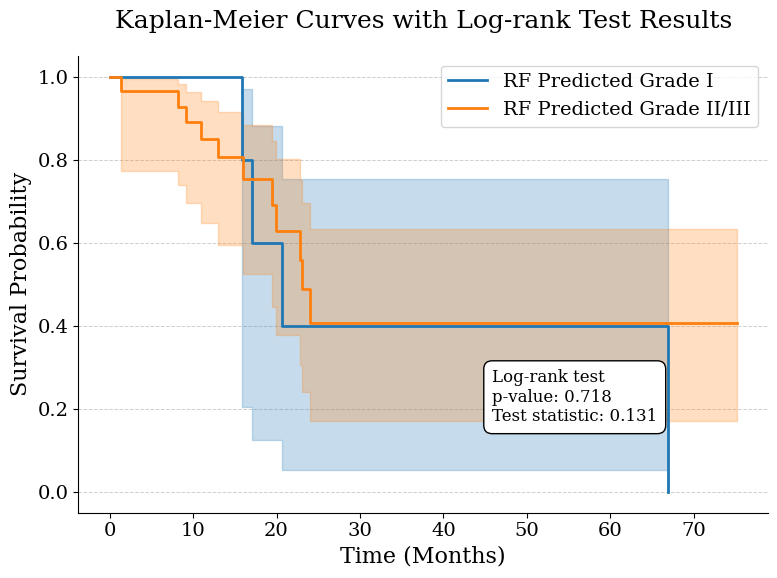

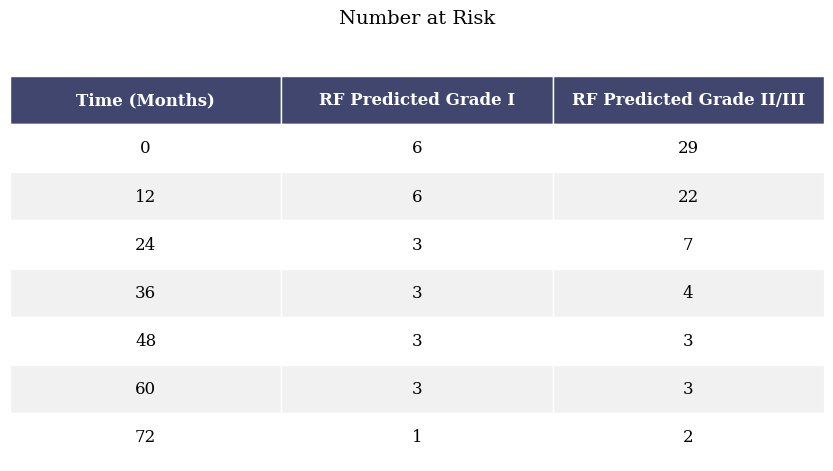

In [23]:
# TODO: REDO THIS CODE!!!

'donor_survival_time'
'donor_vital_status'
'donor_interval_of_last_followup'
'disease_status_last_followup'
'donor_relapse_interval'


# # Add Progression Free Survival and Overall Survival Curves

# # Get the patient IDs in the test set
# # Find the corresponding PFS and OS for each of the patients in the test set (make a new variables y_pfs and y_os to track this)
# # Plot the Kaplan Meier curves for predicted Grade I vs predicted Grade II/III

# df_y_survival = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_patient.txt", sep='\t', index_col=[0, 1])

# patient_ids = patient_ids_test

# # Get the Overall Survival (Months) for the patients in X_test
# y_time_os = df_y_survival.loc[(patient_ids, slice(None)), "Overall Survival (Months)"].reset_index(level=1, drop=True)
# y_status_os = df_y_survival.loc[(patient_ids, slice(None)), "Overall Survival Status"].reset_index(level=1, drop=True)
# y_time_pfs = df_y_survival.loc[(patient_ids, slice(None)), "Progress Free Survival (Months)"].reset_index(level=1, drop=True)
# y_status_pfs = df_y_survival.loc[(patient_ids, slice(None)), "Progression Free Status"].reset_index(level=1, drop=True)

# # Set survival status and progression free status to 0 or 1 and convert times from strings to floats
# y_time_os = y_time_os.astype(float)
# y_status_os = y_status_os.replace({"0:LIVING": 0, "1:DECEASED": 1})
# y_time_pfs = y_time_pfs.astype(float)
# y_status_pfs = y_status_pfs.replace({"0:CENSORED": 0, "1:PROGRESSION": 1})

# y_pred = best_rf_model_overall.predict(X_test)


# # Sample data
# data = {'time': y_time_os,
#         'event': y_status_os,
#         'group': y_pred}

# df = pd.DataFrame(data)

# plot_kaplan_meier_and_at_risk_table(df,'Kaplan-Meier Curves with Log-rank Test Results')


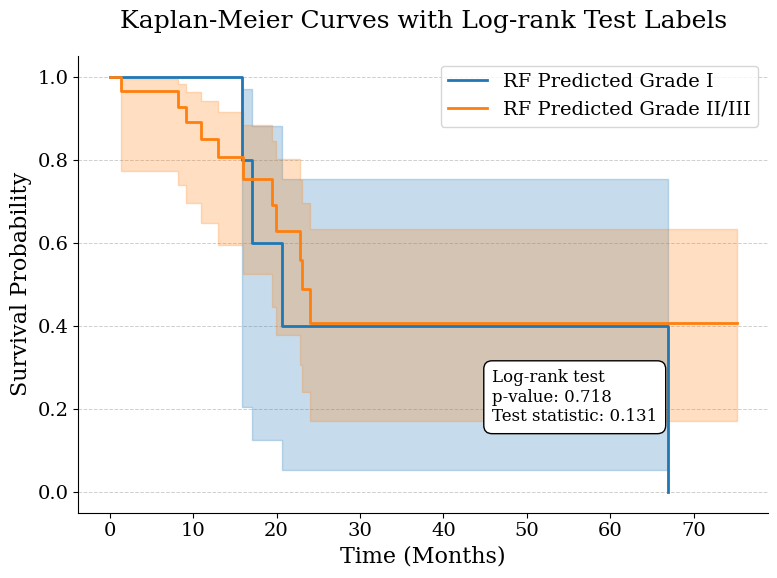

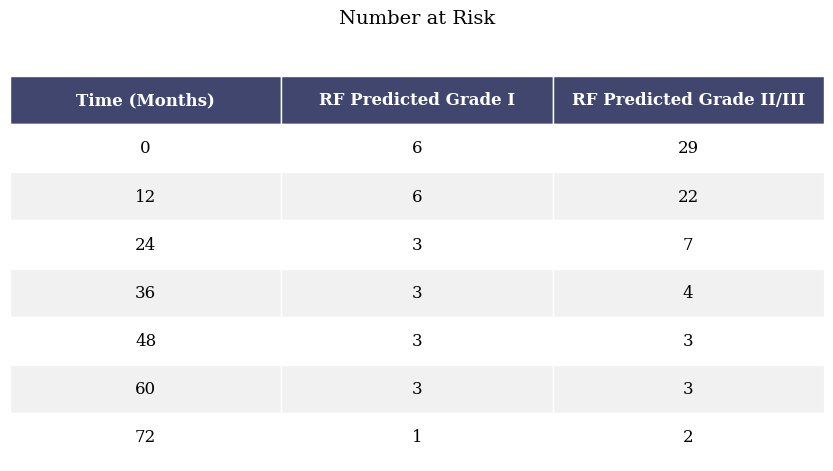

In [24]:
# Plot Progression Free Survival and Overall Survival Curves for Test Labels

y_pred = y_test
# Sample data
data = {'time': y_time_os,
        'event': y_status_os,
        'group': y_pred}
df = pd.DataFrame(data)

plot_kaplan_meier_and_at_risk_table(df,'Kaplan-Meier Curves with Log-rank Test Labels')

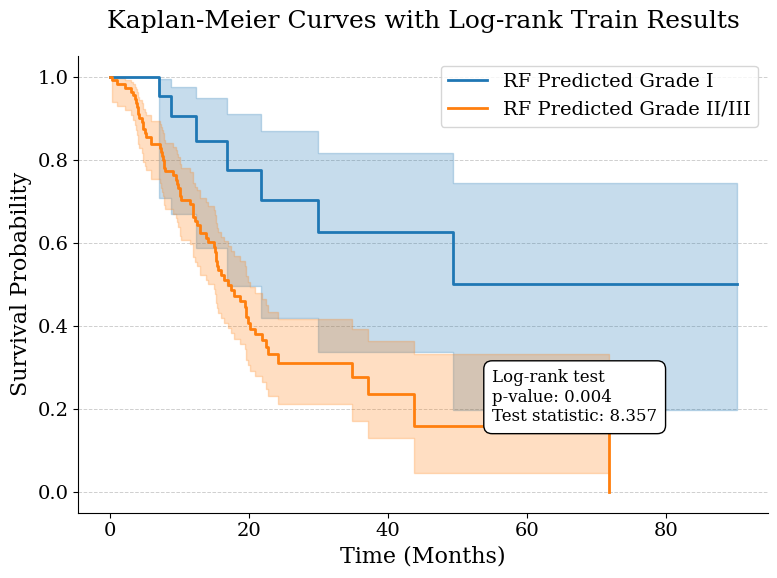

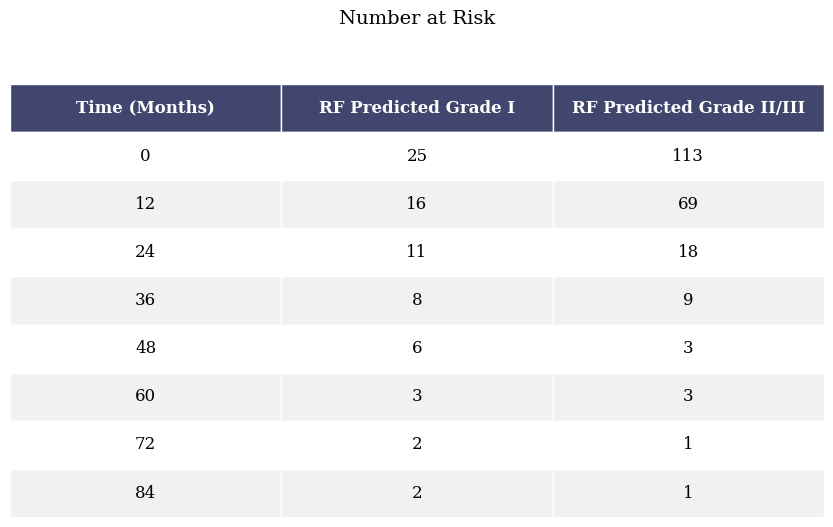

In [25]:
# Add Progression Free Survival and Overall Survival Curves

'''
First, regenerate just train dataset without SMOTE, which may have been used above
SMOTE adds new synthetic data that we don't want to include in our survival curve analysis
'''

'''
Load in the data
'''
X_train=X_train_no_SMOTE
y_train=y_train_no_SMOTE

# Get the patient IDs in the TRAIN SET (this is not a good estimate of the model performance, rather it estimates the predictiveness of grade for survival)
# Find the corresponding PFS and OS for each of the patients in the test set (make a new variables y_pfs and y_os to track this)
# Plot the Kaplan Meier curves for predicted Grade I vs predicted Grade II/III

df_y_survival = pd.read_csv("paad_tcga_pan_can_atlas_2018/data_clinical_patient.txt", sep='\t', index_col=[0, 1])

patient_ids=patient_ids_train
# Get the Overall Survival (Months) for the patients in X_test
y_time_os = df_y_survival.loc[(patient_ids, slice(None)), "Overall Survival (Months)"].reset_index(level=1, drop=True)
y_status_os = df_y_survival.loc[(patient_ids, slice(None)), "Overall Survival Status"].reset_index(level=1, drop=True)
y_time_pfs = df_y_survival.loc[(patient_ids, slice(None)), "Progress Free Survival (Months)"].reset_index(level=1, drop=True)
y_status_pfs = df_y_survival.loc[(patient_ids, slice(None)), "Progression Free Status"].reset_index(level=1, drop=True)

# Set survival status and progression free status to 0 or 1 and convert times from strings to floats
y_time_os = y_time_os.astype(float)
y_status_os = y_status_os.replace({"0:LIVING": 0, "1:DECEASED": 1})
y_time_pfs = y_time_pfs.astype(float)
y_status_pfs = y_status_pfs.replace({"0:CENSORED": 0, "1:PROGRESSION": 1})

y_train_pred = best_rf_model_overall.predict(X_train)

# Sample data
data = {'time': y_time_os,
        'event': y_status_os,
        'group': y_train_pred}

df = pd.DataFrame(data)

plot_kaplan_meier_and_at_risk_table(df,'Kaplan-Meier Curves with Log-rank Train Results')

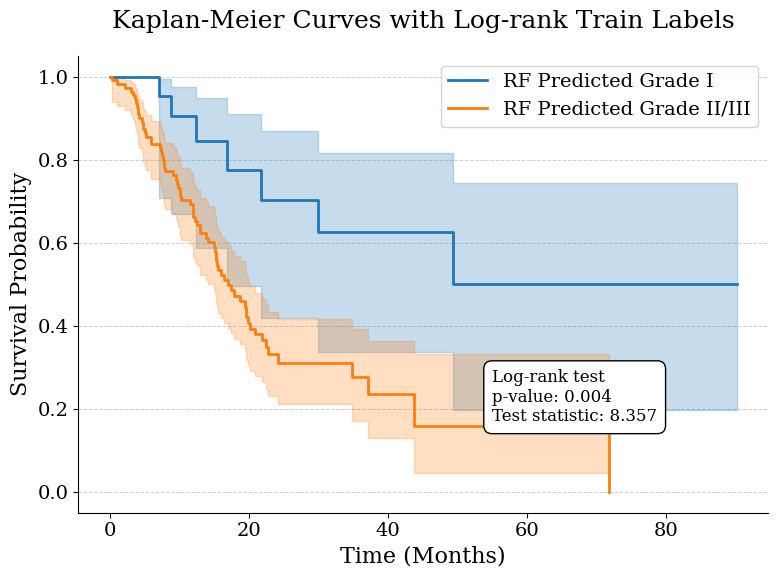

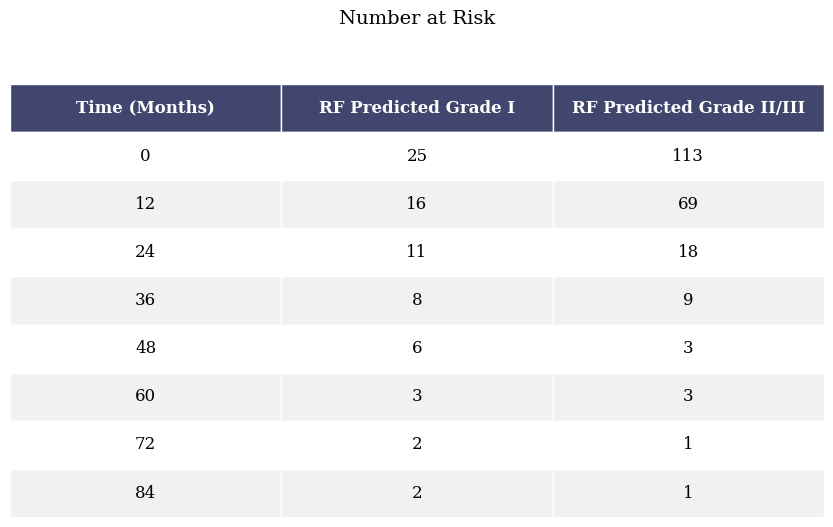

In [26]:
# Add Progression Free Survival and Overall Survival Curves for Train Labels

y_train_pred = y_train

# Sample data
data = {'time': y_time_os,
        'event': y_status_os,
        'group': y_train_pred}

df = pd.DataFrame(data)

plot_kaplan_meier_and_at_risk_table(df,'Kaplan-Meier Curves with Log-rank Train Labels')
